In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
nltk.download('stopwords')
# Path in Collab: /root/nltk_data/corpora/stopwords/english

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#P1 Utility

""" File:  P1_utility_functions.py
    Utility functions used in Phase 1 Pre-processing of the raw chat (.csv) file
"""
import os.path
import re
import nltk
import gensim
from nltk.stem import WordNetLemmatizer


def getStopWords(stopWordFileName):
    """Reads stop-words text file which is assumed to have one word per line.
       Returns stopWordDict.
    """
    stopWordDict = {}
    stopWordFile = open(stopWordFileName, 'r')

    for line in stopWordFile:
        word = line.strip().lower()
        stopWordDict[word] = None
        
    return stopWordDict

def getFileName(prompt):
    """Prompts the user for a valid file which it returns.
    """
    while True:
        fileName = input(prompt+" ")
        if os.path.exists(fileName):
            return fileName
        else:
            print("File not found! Make sure that the file is inside this directory.")

def readRawChats(inFile):
    """
        Reads .csv file and split into transcripts by splitting on the Timestamp which includes the Date.
        The returned transcriptList is a list-of-lists where each "outer" list item contains information about
        a single chat.  
    """

    inFile = open(inFile, "r", encoding = 'utf-8')  # NOTE .csv file assumed to have column-headings line

    dateAtStartCount = 0
    transcriptList = []
    currentTranscriptLines = []

    for line in inFile:
        frontOfLine = line[:6]
        if frontOfLine.count("/") == 2:
            dateAtStartCount += 1
            if dateAtStartCount == 1: #ignore header line
                currentTranscriptLines = [line.strip()]
            else:
                transcriptList.append(currentTranscriptLines)
                currentTranscriptLines = [line.strip()]
        else:
            currentTranscriptLines.append(line.strip())
    transcriptList.append(currentTranscriptLines)
    
    return transcriptList


def findInitialQuestion(transList, transIndex):
    """
        Takes in transList which is a list of strings containing the information about a single chat.
        The index 0 string will contain the Initial Question field, which it returns if it exists; otherwise
        None is returned."
    """
    
    firstCommaIndex = transList[0].find(",")
    if firstCommaIndex == -1:
        print("First comma not found")
        return None
    else:
        secondCommaIndex = transList[0].find(",",firstCommaIndex+1)
        if secondCommaIndex == -1:
            print("Second comma not found")
            return None
        else:
            thirdCommaIndex = transList[0].find(",",secondCommaIndex+1)
            if thirdCommaIndex == -1:
                thirdCommaIndex = len(transList[0])-1
           
            #print(secondCommaIndex, thirdCommaIndex)
            if secondCommaIndex + 1 == thirdCommaIndex:
                return None
            else:
                return transList[0][secondCommaIndex+1:thirdCommaIndex]

            
def generateTranscriptDialogList(trans):
    
    transcriptDialogList = []
    transStr = " ".join(trans)  # merge transcript back to a single string

    #split by time-stamps to get a dialogList
    transTimeIndexList = []
    for index in range(2,len(transStr)-6):
        if transStr[index] == ":" and transStr[index+3] == ":" and transStr[index+1:index+3].isdigit() and transStr[index+4:index+6].isdigit():
            transTimeIndexList.append(index-2)
    dialogList = []
    for i in range(len(transTimeIndexList)-1):
        dialogList.append(transStr[transTimeIndexList[i]:transTimeIndexList[i+1]])
    if len(transTimeIndexList) == 0:
        dialogList.append(transStr)
    else:
        dialogList.append(transStr[transTimeIndexList[-1]:])
    
    return dialogList    

def findInitialQuestionInDialog(dialogList, chatIndex):
    """ If the 'Initial question' column in the .csv file was empty, this function is called
        to find and return the initial question from the chat dialog."""

    for i in range(len(dialogList)):
        helpYouCount = dialogList[i].lower().count("help you")
        welcomeCount = dialogList[i].lower().count("welcome")
        infoDeskCount = dialogList[i].lower().count("info desk")
        try:
            if helpYouCount == 0 and welcomeCount == 0 and infoDeskCount == 0 and len(dialogList[i]) >= 40:
                return dialogList[i]
                
        except:
            print("\n\nNO QUESTION FOUND! ",chatIndex)
            break

def removeTags(fileStr):
    """
        Removes all tags from the chat that start with '<xyz' and end with '</xyz'.
    """
    current = 0
    while True:
        #print("Next char:",fileStr[current])
        openAngleBracketIndex = fileStr.find('<',current)
        if openAngleBracketIndex == -1:
            break
        spaceIndex = fileStr.find(' ', openAngleBracketIndex+1)
        if spaceIndex == -1:
            break
        else:
            current = spaceIndex
        endStr = "</"+fileStr[openAngleBracketIndex+1:spaceIndex]+'>'

        endIndex = fileStr.find(endStr, spaceIndex)
        if endIndex == -1:
            current = spaceIndex
        else:
            endIndex = endIndex+len(endStr)

            #print(openAngleBracketIndex, endStr, endIndex+len(endStr))
            fileStr = fileStr[:openAngleBracketIndex]+ \
                      fileStr[endIndex:]
            #print(fileStr)
            current = openAngleBracketIndex
    return fileStr


"""
NOTE: The nltk.pos_tag function returns the Penn Treebank tag for the word but we just want
whether the word is a noun, verb, adjective or adverb. We need a short simplification routine to translate from
the Penn tag to a simpler tag.
"""
def simplify(penn_tag):
    """ Simplify Penn tags to n (NOUN), v (VERB), a (ADJECTIVE) or r (ADVERB)"""
    pre = penn_tag[0]
    
    if pre == 'J':
        return 'a'
    elif pre == 'R':
        return 'r'
    elif pre == 'V':
        return 'v'
    elif pre == 'N':
        return 'n'
    else:
        return 'r'
        return 'other'

def preprocess(text, stop_words, POS_list):
    """ Preprocesses the text to remove stopwords, lemmatizes each word and only includes
        words that are POS in the global POS_LIST"""

    toks = gensim.utils.simple_preprocess(str(text), deacc=True)
    wn = WordNetLemmatizer()
    return [wn.lemmatize(tok, simplify(pos)) for tok, pos in nltk.pos_tag(toks)
            if tok not in stop_words and simplify(pos) in POS_list]
        
def writeInitialQuestion(chatIndexInCSV, questionFile,  wholeChatsFileTxt, question, questionCount, stopWordsDict, POS_list):
    """ Write a cleaned up version of the initial question to the question file. """
    lemmatizer = nltk.WordNetLemmatizer()
    cleanQuestion = ""
    question = question.lower()

    colonCount = question.count(":")

    if colonCount >= 3:  # time-stamp ##:##:## - person: question
        colonOneIndex = question.find(":")
        colonTwoIndex = question.find(":", colonOneIndex+1)
        colonThreeIndex = question.find(":", colonTwoIndex+1)
        question = question[colonThreeIndex+1:]
    elif colonCount >= 1:
        colonOneIndex = question.find(":")
        question = question[colonOneIndex+1:]
        
    question = question.replace('&#x27;', "'")
    question = question.replace('&#x2F;', " ")
    question = question.replace('&nbsp;', " ")
    question = question.replace('&quot;','"')

    ### HERE CLEAN UP <xyz ......</xyz>, e.g., <a href.....</a>, <span ... </span>

    question = removeTags(question)
    question = question.replace('.','Z')
    question = question.replace('!','Z')
    question = question.replace('?','Z')
    
    masterWordList = []
    sentenceList = question.split("Z")
    for question in sentenceList:
        wordList = question.split()
        cleanQuestion = ""
        for word in wordList:
            cleanWord = ""
            for char in word:
                if char >= 'a' and char <= 'z':
                    cleanWord += char
            if len(cleanWord) > 0 and len(cleanWord) < 30:  #upper bound to eliminate url's
                cleanQuestion += lemmatizer.lemmatize(cleanWord) + " "
        pos_wordList = preprocess(cleanQuestion, stopWordsDict, POS_list)
          
        masterWordList.extend(pos_wordList)

    chatCleaned = " ".join(masterWordList)
    if len(chatCleaned) > 0:
        questionFile.write(chatCleaned)
        wholeChatsFileTxt.write(chatCleaned)
        questionCount += 1
    return questionCount

def writeChatDialog(excelLineNumber, wholeChatsFile,  wholeChatsFileTxt, dialogList, stopWordsDict, POS_list):
    """ Writes a chat's dialog to a line in the text file. """
    for i in range(len(dialogList)):
      
        writeInitialQuestion(excelLineNumber, wholeChatsFile,  wholeChatsFileTxt, dialogList[i], 0, stopWordsDict, POS_list)
        wholeChatsFile.write(" ")  # separate end of this line with start of next line
        wholeChatsFileTxt.write(" ")  # separate end of this line with start of next line
        
   
def writeWholeChatsToFile(transcriptDialogList, dataFileName, stopWordsDict, POS_list):
    """ Writes a whole chat's dialog one per line to a text file.  Removed from
        the line of text is:
        1) time-stamps and names:  e.g., '13:45:42 - Jordan:'
        2) all punctuations
    """

    wholeChatsFile = open(dataFileName+".csv", "w")
    wholeChatsFileTxt = open(dataFileName+".txt", "w")
    wholeChatsCount = 0
    for transcriptDialog in transcriptDialogList:

        if transcriptDialog[1] is not None:
            wholeChatsFile.write(str(transcriptDialog[0])+",")

            # check to see if initial question is already in the chat dialog
            timeStampAndNameList = re.findall(r'[0-9][0-9]:[0-9][0-9]:[0-9][0-9] - [\w\s]+:', transcriptDialog[1])
            
            if len(timeStampAndNameList) == 0:  # no time-stamp so from 'initial question' column of .csv
                # write initial question to file since it is not part of the chat dialog
                writeInitialQuestion(transcriptDialog[0], wholeChatsFile, wholeChatsFileTxt, transcriptDialog[1], 0, stopWordsDict, POS_list)
                wholeChatsFile.write(" ")
                wholeChatsFileTxt.write(" ")
            writeChatDialog(transcriptDialog[0],wholeChatsFile,  wholeChatsFileTxt, transcriptDialog[2], stopWordsDict, POS_list)
            
            #wholeChatsFile.write("\n")
            wholeChatsCount += 1
            wholeChatsFile.write("\n")
            wholeChatsFileTxt.write("\n")
    print("Whole Chats Count:", wholeChatsCount, "written to",dataFileName+".txt")
    wholeChatsFile.close()
    wholeChatsFileTxt.close()

def writeQuestionsOnlyToFile(transcriptDialogList, dataFileName, stopWordsDict, POS_list):
    """ Writes only the initial questions one per line to a text file. 
    """
    questionFile = open(dataFileName+".csv", "w")
    questionTxtFile = open(dataFileName+".txt", "w")
    questionCount = 0
    for transcriptDialog in transcriptDialogList:
        if transcriptDialog[1] is not None:
            currentCount = questionCount
            questionCount = writeInitialQuestion(transcriptDialog[0], questionFile, questionTxtFile, transcriptDialog[1], questionCount, stopWordsDict, POS_list)
            if currentCount < questionCount:
                questionFile.write("\n")
                questionTxtFile.write("\n")
    print("Total Question Count:", questionCount, "written to",dataFileName+".txt")
    questionFile.close()
    questionTxtFile.close()


In [ ]:
#P1 Script

""" File:  P1_preprocess_data.py
    Description:  Takes as input raw chat data .csv file from the LibChat keeping only the columns:
    Timestamp, Duration (seconds), Initial Question, Message Count, and Transcript

    Additionally the chat text data is "cleaned" by: 
    1) removing timestamps, 
    2) removing chat patron and librarian identifiers, 
    3) removing http tags (e.g., URLs), 
    4) removing non-ASCII characters,
    5) removing stopwords, and 
    6) lemmatized words using nltk.WordNetLemmatizer() 

    Four data-set versions of the “cleaned” chat transcripts were prepared:
    1) "onlyQuestionsFile.txt" - Questions only: consists of only the initial question asked by
        the library patron in each chat transcript
    2) "wholeChatsFile.txt" - Whole chats: consists of the whole cleaned chat transcripts
    3) "wholeChatsFilePOS_N_ADJ.txt" - Whole chats with POS (Noun and Adjective): consists of only
       the nouns and adjectives parts-of-speech (POS) from the whole cleaned chat transcripts
    4) "wholeChatsFilePOS_N_ADJ_V.txt" - Whole chats with POS (Noun, Adjective, and Verb): consists
       of only the nouns, adjectives, and verbs parts-of-speech (POS) from the whole cleaned chat transcripts
    The goal of the first two data sets was to see if looking at only the initial question in the
    chats was better than the whole chats. The goal of the last two data sets was to see if varying
    the parts-of-speech retained had any effect on the topic modeling analyses. 

    Takes as input raw chat data .csv file and produces a list-of-lists called transcriptDialogList with a format:
    [[<excel index int>, "Initial question string", [Transcript split by chat responses which including initial
    question]], ...]. This transcriptDialogList is used to write two text files for each of the four
    data-set versions .  Each chat dialog is used to produce one line in the two text files:
    1) the .csv file is formated with one chat per line formatted as:
       chat line # in original .csv, cleaned and pre-processed text of the chat, and
    2) the .txt file is cleaned and pre-processed text of the chat

"""
import nltk

#from P1_utility_functions import *

def main():
    print('Welcome to Phase 1 of the chat analysis which pre-processes a raw chat data .csv file',
          '\nfrom the LibChat keeping only the 5 columns (with column-headings):',
          '\nTimestamp, Duration (seconds), Initial Question, Message Count, and Transcript.',
          '\n\nRunning Phase 1 to pre-process your raw chat data (.csv) will generate four cleaned chat',
          '\nfiles varying the parts of speech or question-only.',
          '\n1) "onlyQuestionsFile.txt" - consists of only the initial questions asked by the library patrons',
          '\n2) "wholeChatsFile.txt" - consists of the whole cleaned chat transcripts',
          '\n3) "wholeChatsFilePOS_N_ADJ.txt" - consists of only the nouns and adjectives parts-of-speech (POS)',
          '\n4) "wholeChatsFilePOS_N_ADJ_V.txt" - consists of only the nouns, adjectives, and verbs parts-of-speech\n')

    prompt = "\nStep 1. Please input the raw LibChat (.csv) file." + \
             '\n(For example: "chatFile.csv"):'
    inputCSVFileName = getFileName(prompt)

    prompt = "\nStep 2. Please input the stop words (.txt) file." + \
             '\n(For example: "stop_words_1_10.txt"):'
    stopWordFileName = getFileName(prompt)

    print("\n\nWARNING:  Depending on the size of your chat data file.  This step might take several minutes.")

    POS_list = ['n','a','v','r']  # n - noun and a - adjective other possibilities: v -verb, r - adverb, 'other'

    print('The file name is: ' + stopWordFileName)
    stopWordsDict = getStopWords(stopWordFileName)
    transcriptList = readRawChats(inputCSVFileName)

    initialQuestionCount = 0
    transIndex = 2  # Assumes Excel .cvs had a column-header in line 1
    transcriptDialogList = []
    for trans in transcriptList:
        transDialogList = generateTranscriptDialogList(trans)
        initialQuestion = findInitialQuestion(trans, transIndex)
        if initialQuestion == None:
            initialQuestion = findInitialQuestionInDialog(transDialogList,transIndex)           
        else:
            initialQuestionCount+= 1
            
        transcriptDialogList.append([transIndex, initialQuestion, transDialogList])
        transIndex += 1

    print("Number of initial questions from Initial Question column of .csv:", initialQuestionCount)

    POS_list = ['n','a','v','r','other']  # n - noun and a - adjective other possibilities: v -verb, r - adverb, 'other'
    writeQuestionsOnlyToFile(transcriptDialogList, "onlyQuestionsFile", stopWordsDict, POS_list)

    writeWholeChatsToFile(transcriptDialogList, "wholeChatsFile", stopWordsDict, POS_list)

    POS_list = ['n','a']  # n - noun and a - adjective other possibilities: v -verb, r - adverb, 'other'
    writeWholeChatsToFile(transcriptDialogList, "wholeChatsFilePOS_N_ADJ", stopWordsDict, POS_list)

    POS_list = ['n','a','v']  # n - noun and a - adjective other possibilities: v -verb, r - adverb, 'other'
    writeWholeChatsToFile(transcriptDialogList, "wholeChatsFilePOS_N_ADJ_V", stopWordsDict, POS_list)
    
    return transcriptDialogList
    
t = main()  # start main running

Welcome to Phase 1 of the chat analysis which pre-processes a raw chat data .csv file 
from the LibChat keeping only the 5 columns (with column-headings): 
Timestamp, Duration (seconds), Initial Question, Message Count, and Transcript. 

Running Phase 1 to pre-process your raw chat data (.csv) will generate four cleaned chat 
files varying the parts of speech or question-only. 
1) "onlyQuestionsFile.txt" - consists of only the initial questions asked by the library patrons 
2) "wholeChatsFile.txt" - consists of the whole cleaned chat transcripts 
3) "wholeChatsFilePOS_N_ADJ.txt" - consists of only the nouns and adjectives parts-of-speech (POS) 
4) "wholeChatsFilePOS_N_ADJ_V.txt" - consists of only the nouns, adjectives, and verbs parts-of-speech



KeyboardInterrupt: ignored

In [ ]:
""" File:  P2_utility_functions.py
    Unility functions for Phase 2 which performs the topic modeling.

    Latent Dirichlet Allocation (LDA), PyMallet
    Here we are used the LDA implementation from GitHub PyMallet at:
    https://github.com/mimno/PyMallet
    The LDA code below is based on their lda_reference.py code written in Python
    The PyMallet project has an MIT License see below.
================================================================================
MIT License

Copyright (c) 2019 mimno

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
===========================================================================
"""
from pprint import pprint  # pretty-printer
from collections import defaultdict
from gensim import corpora
from six import iteritems

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
import os.path

from sklearn.pipeline import Pipeline
from time import time


def getStopWords(stopWordFileName):
    """Reads stop-words text file which is assumed to have one word per line.
       Returns stopWordDict.
    """
    stopWordDict = {}
    stopWordFile = open(stopWordFileName, 'r')

    for line in stopWordFile:
        word = line.strip().lower()
        stopWordDict[word] = None
    stopWordSet = set(stopWordDict)
        
    return stopWordDict, stopWordSet

def getPositiveInteger(prompt):
    """Prompts the user for a valid positive integer which it returns.
    """
    while True:
        inputStr = input(prompt+" ")
        try:
            intValue = int(inputStr)
            if intValue <= 0:
                print("Please enter a positive integer.")
                raise ValueError("positive integer only")
            return intValue
        except:
            print("Invalid positive integer")

def getFileName(prompt):
    """Prompts the user for a valid file which it returns.
    """
    while True:
        fileName = input(prompt+" ")
        if os.path.exists(fileName):
            return fileName
        else:
            print("File not found! Make sure that the file is inside this directory.")

# used in LDA sklearn
def readChatCorpusFile(chatFileName):
    """ Read specified chat corpus file (which should be a preprocessed
        text file with one chat per line) and returns the documents list
        where each chat being a string in the list.
    """
    documentsFile = open(chatFileName, 'r')

    documentsList = []
    for documentLine in documentsFile:
        documentLine = documentLine.lower()
        if len(documentLine) > 0:
            documentsList.append(documentLine)
    #print("len(documents)",len(documentsList))
    return documentsList

def print_top_words(model, feature_names, n_top_words):
    """ Displays the specified top topics and top words to screen"""
    for topic_idx, topic in enumerate(model.components_):
        
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        message += "\n "
        message += " ".join([feature_names[i]+" ("+str(model.components_[topic_idx][i])+")\n"
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

def write_file_top_words(model, feature_names, n_top_words, fileName):
    """ Writes the specified top topics and top words to the specified fileName"""
    outputFile = open("raw_"+fileName, 'w')
    outputFileTopics = open(fileName, 'w')
    outputFile.write("File: "+"raw_"+fileName+"\n\n")
    outputFileTopics.write("File: "+fileName+"\n\n")
    topicList = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        topicStr = " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        topicList.append(topicStr)
        outputFileTopics.write(topicStr+"\n")

        message += topicStr + "\n "
        message += " ".join([feature_names[i]+" ("+str(model.components_[topic_idx][i])+")\n"
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        outputFile.write(message+"\n")

    outputFile.close()
    outputFileTopics.close()
    return topicList

# used in LSA with gensim
def write_LSA(model_lsi, n_topics, n_words_per_topic, fileName):
    """ Writes the specified top topics and top words to the specified fileName"""
    topicList = model_lsi.print_topics(n_topics)
    ##print("topicList",topicList)
    corpus_tfidf_and_lsa_fileName = "raw_" + fileName
    corpus_tfidf_and_lsa_file = open(corpus_tfidf_and_lsa_fileName, 'w')
    outputFile = open(fileName,'w')
    corpus_tfidf_and_lsa_file.write("File: " + corpus_tfidf_and_lsa_fileName + '\n\n')
    outputFile.write("File: " + fileName + '\n\n')
    listOfTopics = []
    for topicIndex in range(n_topics):
        corpus_tfidf_and_lsa_file.write(str(topicList[topicIndex])+'\n')
        line = str(topicList[topicIndex])
        topicString = ""
        startIndex = 0
        for count in range(n_words_per_topic):
            wordStart = line.find('*"', startIndex) + 2
            wordEnd = line.find('"', wordStart) - 1
            topicString += line[wordStart:wordEnd+1] + " "
            startIndex = wordEnd + 1
        outputFile.write(topicString+"\n")
        listOfTopics.append(topicString)

    outputFile.close()
    corpus_tfidf_and_lsa_file.close()
    return listOfTopics


# create a vector stream to avoid loading the whole vector into memory at one time
class MyCorpus(object):
    def __init__(self, documentsList, dictionary):
        self._docsList = documentsList
        self.myDictionary = dictionary
        
    def __iter__(self):
#        for line in open(FILE_NAME_OF_CORPUS+'_lemmatized.txt'):
        for line in self._docsList:
            # assume there's one document per line, tokens separated by whitespace
            yield self.myDictionary.doc2bow(line.lower().split())


def createCorpusDictionary(documentsList, stoplist):
    # collect statistics about all tokens, i.e., words
    dictionary = corpora.Dictionary(line.lower().split() for line in documentsList)
    # remove stop words and words that appear only once
##    stop_ids = [
##        dictionary.token2id[stopword]
##        for stopword in stoplist
##        if stopword in dictionary.token2id
##    ]
    once_ids = [tokenid for tokenid, docfreq in iteritems(dictionary.dfs) if docfreq == 1]
##    dictionary.filter_tokens(stop_ids + once_ids)  # remove stop words and words that appear only once
    dictionary.filter_tokens(once_ids)  # remove words that appear only once
    dictionary.compactify()  # remove gaps in id sequence after words that were removed

    #dictionary.save(FILE_NAME_OF_CORPUS+'.dict')  # store the dictionary, for future reference
    corpus_memory_friendly = MyCorpus(documentsList,dictionary)  # doesn't load the corpus into memory!

    #corpora.MmCorpus.serialize(FILE_NAME_OF_CORPUS+'.mm', corpus_memory_friendly)
    return dictionary, corpus_memory_friendly

## functions used in PyMallet_LDA
""" 
    Here we are used the LDA implementation from GitHub PyMallet at:
    https://github.com/mimno/PyMallet
    The LDA code below is based on their lda_reference.py code written in Python
    The PyMallet project has an MIT License see below.

    INPUT FILES:
    Previously created preprocessed chat corpus from either:
    1) wholeChatsFilePOS_N_ADJ_V.csv -- preprocessing keeping nouns, adjectives, and verbs
    2) wholeChatsFilePOS_N_ADJ.csv -- preprocessing keeping nouns and adjectives
    3) wholeChatsFile.csv -- NO POS preprocessing so all parts of speech
    4) onlyQuestionsFile.csv -- Only initial question of chats

    OUTPUT FILES:
    1) "raw_" text (.txt) file listing topics with each word scored
    2) "PyMallet_LDA_" text (.txt) file containing only the text for the
       specified number of topics with the specified number of words per topic

MIT License

Copyright (c) 2019 mimno

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

"""

import re, sys, random, math
import numpy as np
from collections import Counter
from timeit import default_timer as timer

from time import time

def sample(documents, vocabulary_size, word_topics, topic_totals, word_counts, num_iterations, n_topics, doc_smoothing = 0.5, word_smoothing = 0.01):
    smoothing_times_vocab_size = word_smoothing * vocabulary_size

    word_pattern = re.compile("\w[\w\-\']*\w|\w")

    for iteration in range(num_iterations):
        
        for document in documents:
            
            doc_topic_counts = document["topic_counts"]
            token_topics = document["token_topics"]
            doc_length = len(token_topics)
            for token_topic in token_topics:
                
                w = token_topic["word"]
                old_topic = token_topic["topic"]
                word_topic_counts = word_topics[w]
                
                ## erase the effect of this token
                word_topic_counts[old_topic] -= 1
                topic_totals[old_topic] -= 1
                doc_topic_counts[old_topic] -= 1
                
                ###
                ### SAMPLING DISTRIBUTION
                ###
                
                ## Does this topic occur often in the document?
                topic_probs = (doc_topic_counts + doc_smoothing) / (doc_length + n_topics * doc_smoothing)
                ## Does this word occur often in the topic?
                topic_probs *= (word_topic_counts + word_smoothing) / (topic_totals + smoothing_times_vocab_size)
                
                ## sample from an array that doesn't sum to 1.0
                sample = random.uniform(0, np.sum(topic_probs))
                
                new_topic = 0
                while sample > topic_probs[new_topic]:
                    sample -= topic_probs[new_topic]
                    new_topic += 1
                
                ## add back in the effect of this token
                word_topic_counts[new_topic] += 1
                topic_totals[new_topic] += 1
                doc_topic_counts[new_topic] += 1
                
                token_topic["topic"] = new_topic               

def entropy(p):
    ## make sure the vector is a valid probability distribution
    p = p / np.sum(p)
    
    result = 0.0
    for x in p:
        if x > 0.0:
            result += -x * math.log2(x)
            
    return result

def print_topic(topic):
    sorted_words = sorted(vocabulary, key=lambda w: word_topics[w][topic], reverse=True)
    
    for i in range(20):
        w = sorted_words[i]
        print("{}\t{}".format(word_topics[w][topic], w))

def print_all_topics():
    for topic in range(NUMBER_OF_TOPICS_PRINTED):
        sorted_words = sorted(vocabulary, key=lambda w: word_topics[w][topic], reverse=True)
        print(" ".join(sorted_words[:20]))


def PyMallet_LDA(docs, n_topics, stoplist = set()):
    word_pattern = re.compile("\w[\w\-\']*\w|\w")
    word_counts = Counter()

    documents = []
    word_topics = {}
    topic_totals = np.zeros(n_topics)


    for line in docs:
        #line = line.lower()
        
        tokens = word_pattern.findall(line)
        
        ## remove stopwords, short words, and upper-cased words
        tokens = [w for w in tokens if not w in stoplist and len(w) >= 3 and not w[0].isupper()]
        word_counts.update(tokens)
        
        doc_topic_counts = np.zeros(n_topics)
        token_topics = []
        
        for w in tokens:
            
            ## Generate a topic randomly
            topic = random.randrange(n_topics)
            token_topics.append({ "word": w, "topic": topic })
            
            ## If we haven't seen this word before, initialize it
            if not w in word_topics:
                word_topics[w] = np.zeros(n_topics)
            
            ## Update counts: 
            word_topics[w][topic] += 1
            topic_totals[topic] += 1
            doc_topic_counts[topic] += 1
        
        documents.append({ "original": line, "token_topics": token_topics, "topic_counts": doc_topic_counts })

    ## Now that we're done reading from disk, we can count the total
    ##  number of words.
    vocabulary = list(word_counts.keys())
    vocabulary_size = len(vocabulary)

    num_iterations = 100
    sample(documents, vocabulary_size, word_topics, topic_totals, word_counts, num_iterations, n_topics, doc_smoothing = 0.5, word_smoothing = 0.01)

    return vocabulary, word_topics

def write_PyMallet_LDA(vocabulary, word_topics, n_topics, n_words_per_topic, fileName):
    """ Writes the results of PyMallet LDA to files and returns the resulting topics as
        stings in topicList.
    """
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")
    rawFileName = "raw_"+fileName
    outputFileRaw = open(rawFileName, 'w')
    outputFileRaw.write("File: " + rawFileName +"\n\n")
    topicList = []
    for topic in range(n_topics):
        sorted_words = sorted(vocabulary, key=lambda w: word_topics[w][topic], reverse=True)
        topicStr = " ".join(sorted_words[:n_words_per_topic])
        topicList.append(topicStr)
        outputFile.write(topicStr+"\n")
        outputFileRaw.write(topicStr+"\n")
        #print(topicStr)
        for i in range(n_words_per_topic):
            w = sorted_words[i]
            #print("{}\t{}".format(word_topics[w][topic], w))
            outputFileRaw.write("{}\t{}".format(word_topics[w][topic], w) +"\n")
        
    outputFile.close()
    outputFileRaw.close()
    return topicList

## functions used in the topic coherence metric calculations
import math

EPSILON = 0.000000001

def calculateTopicCoherenceMetrics(documentsList, topicsList, stopWordDict = {}):
    """ Calculates and returns the topic coherence metrics: averagePMI, averageLCP, averageNZ
        for the set of topics in topicsList and the reference corpus in documentsList
    """
    outputFileName = "TC_metrics_.txt"

    coOccurrenceDict = {}
    wordDict = {}
    topicsList, topicsCoOccurrenceList, coOccurrenceDict, wordDict = findcoOoccurrencesAndWordsInTopics(topicsList)

    numberOfTopics = len(topicsList)
    
    docCount = tallycoOoccurrencesAndWordsInDocs(documentsList, coOccurrenceDict, wordDict)

    makeProbabilities(docCount, coOccurrenceDict, wordDict)

    outputFile = open(outputFileName, 'w')

    outputFile.write("File: "+outputFileName+"\n\n")
    
    sumPMI = 0.0
    sumLCP = 0.0
    sumNZ = 0
    index = 0
    for topicCoOccurrence in topicsCoOccurrenceList:
        topicPMI = calculateTopicPMI(topicCoOccurrence, coOccurrenceDict, wordDict)
        topicLCP = calculateTopicLCP(topicCoOccurrence, coOccurrenceDict, wordDict)
        topicNZ = calculateTopicNZ(topicCoOccurrence, coOccurrenceDict)
        outputFile.write(topicsList[index]+"\n")
        outputFile.write("PMI = %.3f  " % (topicPMI))
        outputFile.write("LCP = %.3f  " % (topicLCP))
        outputFile.write("NZ = %d\n" % (topicNZ))
        sumPMI += topicPMI
        sumLCP += topicLCP
        sumNZ += topicNZ
        index += 1
    averagePMI = sumPMI/numberOfTopics
    averageLCP = sumLCP/numberOfTopics
    averageNZ = sumNZ/numberOfTopics
    outputFile.write("\nAverage PMI of all topics: %.3f\n" % (averagePMI))
    outputFile.write("\nAverage LCP of all topics: %.3f\n" % (averageLCP))
    outputFile.write("\nAverage NZ of all topics: %.3f\n" % (averageNZ))
    outputFile.close()
    return averagePMI, averageLCP, averageNZ

def makeProbabilities(docCount, coOccurrenceDict, wordDict):
    """ Converses the raw counts in the coOccurrenceDict and wordDict into probabilities."""
    for coOccurrence in coOccurrenceDict:
        coOccurrenceDict[coOccurrence] /= float(docCount)
    for word in wordDict:
        wordDict[word] /= float(docCount)

def calculateTopicPMI(topicCoOccurrenceList, coOccurrenceDict, wordDict):
    """ Calculates and returns a topic's total PMI. """ 
    sumPMI = 0.0
    for topicCoOccurrence in topicCoOccurrenceList:
        sumPMI += calculatePMI(topicCoOccurrence, coOccurrenceDict, wordDict)
    return sumPMI/len(topicCoOccurrenceList)

def calculateTopicLCP(topicCoOccurrenceList, coOccurrenceDict, wordDict):
    """ Calculates and returns a topic's total LCP. """ 
    sumLCP = 0.0
    for topicCoOccurrence in topicCoOccurrenceList:
        firstWord, secondWord = topicCoOccurrence
        sumLCP += calculateLCP(firstWord, topicCoOccurrence, coOccurrenceDict, wordDict)
        sumLCP += calculateLCP(secondWord, topicCoOccurrence, coOccurrenceDict, wordDict)
    return sumLCP/(2*len(topicCoOccurrenceList))

def calculateTopicNZ(topicCoOccurrenceList, coOccurrenceDict):
    """ Calculates and returns a topic's total NZ. """ 
    sumNZ = 0
    for topicCoOccurrence in topicCoOccurrenceList:
        if coOccurrenceDict[topicCoOccurrence] == 0.0:
            sumNZ += 1
    return sumNZ

def calculatePMI(topicCoOccurrence, coOccurrenceDict, wordDict):
    """ Calculates and returns the PMI for a pair of words in the topicCoOccurrence tuple. """
    wordI, wordJ = topicCoOccurrence
    PMI = math.log((coOccurrenceDict[topicCoOccurrence]+EPSILON)/(wordDict[wordI]*wordDict[wordJ]),10)
    return PMI
        
        
def calculateLCP(word, topicCoOccurrence, coOccurrenceDict, wordDict):
    """ Calculates and returns the LCP for a word in the pair of words in the topicCoOccurrence tuple. """
    LCP = math.log((coOccurrenceDict[topicCoOccurrence]+EPSILON)/(wordDict[word]),10)
    return LCP
                
def tallycoOoccurrencesAndWordsInDocs(documentsList, coOccurrenceDict, wordDict):
    """ Tallys across all the documents in documentsList the word pair co-occurrences in coOccurrenceDict, and
        individual words in wordDict."""
    docCount = 0
    for document in documentsList:
        emptyDoc = tallyCoOccurrencesInDoc(document, coOccurrenceDict, wordDict)
        if not emptyDoc:
            docCount += 1
    return docCount

def tallyCoOccurrencesInDoc(document, coOccurrenceDict, wordDict):
    """ Tallys for an individual document the word pair co-occurrences in coOccurrenceDict, and
        individual words in wordDict."""
    docCoOccurrenceDict = {}
    docWordDict = {}
    
    wordList = document.strip().split()
    if len(wordList) == 0:
        return True   # empty document
    
    # eliminate duplicate words by converting to a set and back
    wordSet = set(wordList)
    wordList = list(wordSet)

    wordList.sort()
    for first in range(len(wordList)):
        if wordList[first] in wordDict:
            wordDict[wordList[first]] += 1
        for second in range(first+1,len(wordList)):
            coOccurrenceTuple = (wordList[first], wordList[second])
            if coOccurrenceTuple in coOccurrenceDict:
                coOccurrenceDict[coOccurrenceTuple] += 1
    return False   # not empty document

def findcoOoccurrencesAndWordsInTopics(topicsList):
    """ Processes the topics file and returns:
        topicsList - list of strings with one whole topic as a string,
        topicsCoOccurrenceList - a list-of-lists with the inner-list being the list word pairs as tuples within a topic,
        coOccurrenceDict - keys are tuple of word pairs that co-occur in the topics with their associated values of 0,
        wordDict - keys are words that occur in the topics with their associate values of 0."""

    topicsCoOccurrenceList = []
    coOccurrenceDict = {}
    wordDict = {}
    topicTupleList = []
    for line in topicsList:
        topicTupleList = []
        wordList = line.strip().split()
        wordList.sort()
        for first in range(len(wordList)):
            wordDict[wordList[first]] = 0
            for second in range(first+1,len(wordList)):
                coOccurrenceTuple = (wordList[first], wordList[second])
                coOccurrenceDict[coOccurrenceTuple] = 0
                topicTupleList.append(coOccurrenceTuple)
        topicsCoOccurrenceList.append(topicTupleList)
    return topicsList, topicsCoOccurrenceList,coOccurrenceDict, wordDict

def tallyTriOccurrencesInWindow(document, windowSize, triOccurrenceDict, wordFreqDict, stopWordDict):
    """ Tally the tri-occurrences of non-stop words in all documents of a given window size. """
    wordList = document

    initialChuckSize = min(len(wordList), windowSize)

    # process initial window size or whole line if it is smaller than window size
    for first in range(initialChuckSize-2):
        if wordList[first] in wordFreqDict:
            wordFreqDict[wordList[first]] += 1
        else:
            wordFreqDict[wordList[first]] = 1
            
        for second in range(first+1,initialChuckSize-1):          
            for third in range(second+1,initialChuckSize):          
                if wordList[first] != wordList[second] and \
                   wordList[first] != wordList[third] and \
                   wordList[second] != wordList[third] and \
                   wordList[first] not in stopWordDict and \
                   wordList[second] not in stopWordDict and \
                   wordList[third] not in stopWordDict:
                    words = [wordList[first],wordList[second],wordList[third]]
                    words.sort()
                    triOccurrenceTuple = (words[0], words[1], words[2])
                    if triOccurrenceTuple in triOccurrenceDict:
                        triOccurrenceDict[triOccurrenceTuple] += 1
                    else:
                        triOccurrenceDict[triOccurrenceTuple] = 1

    # slide the window down the whole length of the line
    for nextWordIndex in range(windowSize, len(wordList)):
        if wordList[nextWordIndex] in wordFreqDict:
            wordFreqDict[wordList[nextWordIndex]] += 1
        else:
            wordFreqDict[wordList[nextWordIndex]] = 1
        for second in range(nextWordIndex -1, nextWordIndex-windowSize+2, -1):
            for third in range(second-1,nextWordIndex-windowSize+1, -1):          
                if wordList[nextWordIndex] != wordList[second] and \
                   wordList[nextWordIndex] != wordList[third] and \
                   wordList[second] != wordList[third] and \
                   wordList[nextWordIndex] not in stopWordDict and \
                   wordList[second] not in stopWordDict and \
                   wordList[third] not in stopWordDict:
                    words = [wordList[nextWordIndex],wordList[second],wordList[third]]
                    words.sort()
                    triOccurrenceTuple = (words[0], words[1], words[2])
                    if triOccurrenceTuple in triOccurrenceDict:
                        triOccurrenceDict[triOccurrenceTuple] += 1
                    else:
                        triOccurrenceDict[triOccurrenceTuple] = 1

def tallyCoOccurrencesInWindow(document, windowSize, coOccurrenceDict, wordFreqDict, stopWordDict):
    """ Tally the co-occurrences of non-stop words in all documents of a given window size. """
    wordList = document

    initialChuckSize = min(len(wordList), windowSize)

    # process initial window size or whole line if it is smaller than window size
    for first in range(initialChuckSize):
        if wordList[first] in wordFreqDict:
            wordFreqDict[wordList[first]] += 1
        else:
            wordFreqDict[wordList[first]] = 1
            
        for second in range(first+1,initialChuckSize):          
            if wordList[first] != wordList[second] and \
               wordList[first] not in stopWordDict and \
               wordList[second] not in stopWordDict:
                if wordList[first] < wordList[second]:
                    coOccurrenceTuple = (wordList[first], wordList[second])
                elif wordList[first] > wordList[second]:
                    coOccurrenceTuple = (wordList[second], wordList[first])
                if coOccurrenceTuple in coOccurrenceDict:
                    coOccurrenceDict[coOccurrenceTuple] += 1
                else:
                    coOccurrenceDict[coOccurrenceTuple] = 1

    # slide the window down the whole length of the line
    for nextWordIndex in range(windowSize, len(wordList)):
        if wordList[nextWordIndex] in wordFreqDict:
            wordFreqDict[wordList[nextWordIndex]] += 1
        else:
            wordFreqDict[wordList[nextWordIndex]] = 1
        for otherWordIndex in range(nextWordIndex-windowSize+1, nextWordIndex):
            if wordList[nextWordIndex] != wordList[otherWordIndex] and \
               wordList[nextWordIndex] not in stopWordDict and \
               wordList[otherWordIndex] not in stopWordDict:
                if wordList[nextWordIndex] < wordList[otherWordIndex]:
                    coOccurrenceTuple = (wordList[nextWordIndex], wordList[otherWordIndex])
                elif wordList[nextWordIndex] > wordList[otherWordIndex]:
                    coOccurrenceTuple = (wordList[otherWordIndex], wordList[nextWordIndex])
                if coOccurrenceTuple in coOccurrenceDict:
                    coOccurrenceDict[coOccurrenceTuple] += 1
                else:
                    coOccurrenceDict[coOccurrenceTuple] = 1

In [ ]:
""" File:  P2_unsupervised_topic_modeling.py  

    Description:  Loads a previously created preprocessed chat corpus, then performs
    topic modeling utilizing unsupervised techniques of:
    1) Latent Semantic Analysis (TF-IDF & LSA) using gensim
    2) probabilistic Latent Semantic Analysis (TF-IDF & pLSA) using gensim
    3) Latent Dirichlet Allocation (LDA) using scikit-learn.org (sklearn) LDA module
    4) Latent Dirichlet Allocation (LDA), PyMallet
    Here we are used the LDA implementation from GitHub PyMallet at:
    https://github.com/mimno/PyMallet
    The LDA code below is based on their lda_reference.py code written in Python
    The PyMallet project has an MIT License see below.
================================================================================
MIT License

Copyright (c) 2019 mimno

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
===========================================================================
    INPUT FILES:  User inputs file to process
    Previously created preprocessed chat corpus from P1_preprocess_data.py either:
    1) wholeChatsFilePOS_N_ADJ_V.txt -- preprocessing keeping nouns, adjectives, and verbs
    2) wholeChatsFilePOS_N_ADJ.txt -- preprocessing keeping nouns and adjectives
    3) wholeChatsFile.txt -- NO POS preprocessing so all parts of speech
    4) onlyQuestionsFile.txt -- Only initial question of chats

    OUTPUT FILES for each of the 4 unsupervised topic modeling techniques:
    1) "raw_" text (.txt) file listing topics with each word scored
    2) "LDA_" text (.txt) file containing only the text for the
       specified number of topics with the specified number of words per topic

    OUTPUT FILES for to aid the semi-supervised topic modeling techniques of Phase 3:
    1) possible_2_word_anchors.txt most frequent 2-word occurrence across combined topics
       of all four unsupervised topic modeling techniques
    2) possible_3_word_anchors.txt most frequent 3-word occurrence across combined topics
       of all four unsupervised topic modeling techniques      
    
"""
import os.path
from pprint import pprint  # pretty-printer
from collections import defaultdict
from gensim import corpora
from gensim import models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from time import time

#from P2_utility_functions import *

storageModels = {}
def main():
    # ask users to input the name of the csv file cleaned, make sure it contains the column of 'body'
    print('Welcome to Phase 2 which runs the unsupervised topic modeling techniques.',
          '\n\nYou should have first run Phase 1 to pre-process your chat data.',
          '\nIt would generate cleaned chat files varying the parts of speech or question-only.',
          '\nFiles generated are: wholeChatsFile.txt, wholeChatsFilePOS_N_ADJ_V.txt,',
          '\nwholeChatsFilePOS_N_ADJ.txt, and onlyQuestionsFile.txt.\n')

    prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
             '\n(For example: "wholeChatsFile.txt"):'
    fileName = getFileName(prompt)
    chats = readChatCorpusFile(fileName)

    modelDict = {'PyMallet LDA':run_PyMallet_LDA, 'LDA':runLDA,
                 'TF-IDF & LSA':run_TFIDF_LSA, 'TF-IDF & pLSA':run_TFIDF_pLSA}

    n_topics = getPositiveInteger('\nStep 2. Please specify the number of topics. (suggested range 10-20)\n')
    n_words_per_topic = getPositiveInteger('\nStep 3. Please specify the number of words per topics. (suggested range 5-10)\n')

    combinedTopicsAcrossAllTechniques = []
    for model in modelDict:
        print("="*35)
        print("\nPerforming", model,"topic modeling -- please wait it might take a couple minutes!")
        topicList = modelDict[model](chats, n_topics, n_words_per_topic)
        averagePMI, averageLCP, averageNZ = calculateTopicCoherenceMetrics(chats, topicList)
        print("\nResults for",model," TC-PMI %3.3f, TC-LCP %3.3f, TC-NZ %3.3f:" % (averagePMI, averageLCP, averageNZ))
        for topic in topicList:
            print(topic)
        combinedTopicsAcrossAllTechniques.extend(topicList)

    # generate files of possible anchors for semi-supervised topic modeling techniques
    coOccurrenceDict, triOccurrenceDict = generate_Co_and_Tri_occurrence_dictionary(combinedTopicsAcrossAllTechniques,n_words_per_topic)
    writeOccurrenceFile(2, coOccurrenceDict)
    writeOccurrenceFile(3, triOccurrenceDict)

    #save dictionary in global storage variable
    storageModels = modelDict

def runLDA(documents,n_topics, n_words_per_topic, max_features=1000, stop_words='english'):
    """ Performs LDA topic modeling and return resulting topics as strings in topicList """
    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    tf = tf_vectorizer.fit_transform(documents)
    tf_feature_names = tf_vectorizer.get_feature_names()
    # Fit the LDA model
    lda_model = LatentDirichletAllocation(n_topics, max_iter=50, learning_method='online',
                                    learning_decay = 0.7,
                                    learning_offset=50.,
                                    random_state=0)
    lda_fit = lda_model.fit(tf)
    lda_output = lda_model.transform(tf)

    fileName = "LDA_"+"_"+str(n_topics)+"topics_"+str(n_words_per_topic)+"words.txt"
    topicList = write_file_top_words(lda_fit, tf_feature_names, n_words_per_topic, fileName)
    return topicList

def run_TFIDF_pLSA(documents,n_topics, n_words_per_topic, max_features=1000, stop_words='english'):
    """ Performs TF-IDF and pLSA topic modeling and return resulting topics as strings in topicList """
    # Vectorize raw documents to tf-idf matrix: 
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(documents)
    nmf = NMF(n_components=n_topics, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    fileName = "TFIDF_pLSA_"+str(n_topics)+"topics_"+str(n_words_per_topic)+"words.txt"
    topicList = write_file_top_words(nmf, tfidf_feature_names, n_words_per_topic, fileName)
    return topicList

def run_PyMallet_LDA(documents, n_topics, n_words_per_topic, fileNameCorpus=""):
    """ Performs PyMallet LDA topic modeling and return resulting topics as strings in topicList """
    vocabulary, word_topics = PyMallet_LDA(documents, n_topics)
    fileName = "PyMallet_LDA_"+fileNameCorpus+"_"+str(n_topics) \
               +"topics_"+str(n_words_per_topic)+"words.txt"

    topicList = write_PyMallet_LDA(vocabulary, word_topics, n_topics, n_words_per_topic, fileName)

    return topicList

def run_TFIDF_LSA(documents,n_topics, n_words_per_topic):
    """ Performs TF-IDF and LSA topic modeling and return resulting topics as strings in topicList """
    
    from nltk.corpus import stopwords
    stoplist = set(stopwords.words('english'))  # preprocessing removed stop words already...
    dictionary, corpus = createCorpusDictionary(documents, stoplist)
    tfidf = models.TfidfModel(corpus)  # step 1 -- initialize a model

    # Apply a transformation to a whole corpus 
    corpus_tfidf = tfidf[corpus]

    # Initialize an LSI transformation
    numberOfTopics = 300 # (recommended between 200-500)
    lsi = models.LsiModel(corpus_tfidf, id2word = dictionary, num_topics=numberOfTopics)
    # create a double wrapper over chat corpus: bow -> tfidf -> fold-in-lsi
    corpus_lsi = lsi[corpus_tfidf]
    fileName = "TFIDF_LSA_"+str(n_topics)+"topics_"+str(n_words_per_topic)+"words.txt"
    topicList = write_LSA(lsi, n_topics, n_words_per_topic, fileName)
    return topicList
    
def generate_Co_and_Tri_occurrence_dictionary(combinedTopicsAcrossAllTechniques,n_words_per_topic):
    """ To aid the semi-supervised topic modeling techniques of Phase 3, determines the
        co-occurrences (2-words) and tri-occurrences across combined topics of all four
        unsupervised topic modeling techniques.
    """
    coOccurrenceDict = {}
    triOccurrenceDict = {}
    wordFreqDict = {}
    wordFreqDict2 = {}
    windowSize = n_words_per_topic
    stopWordDict = {}  #stop words previously removed
    combinedTopicsFile = open("combinedTopicsFile.txt", 'w')
    for topic in combinedTopicsAcrossAllTechniques:
        document = topic.split()
        tallyTriOccurrencesInWindow(document, windowSize, triOccurrenceDict, wordFreqDict, stopWordDict)
        tallyCoOccurrencesInWindow(document, windowSize, coOccurrenceDict, wordFreqDict2, stopWordDict)
        combinedTopicsFile.write(topic+"\n")
    combinedTopicsFile.close()
    return coOccurrenceDict, triOccurrenceDict

def writeOccurrenceFile(occurrenceSize, occurrenceDict):
    """ Called twice to generate two files to aid Phase 3 semi-supervised topic modeling:
        1) possible_2_word_anchors.txt most frequent 2-word occurrence across combined
           topics of all four unsupervised topic modeling techniques, and
        2) possible_3_word_anchors.txt most frequent 3-word occurrence across combined
           topics of all four unsupervised topic modeling techniques.
    """
    occurrencesFile = open("possible_"+str(occurrenceSize)+"_word_anchors.txt", 'w')
    occurrencesFile.write("Possible "+str(occurrenceSize)+" word anchors for semi-supervised topic modeling.\n")
    occurrencesFile.write("Found from most frequently occuring "+ str(occurrenceSize)+ "-word occurrences from\n" +
                          "all topics found by supervised topic modeling techniques:\n" +
                          "LDA, PyMallet_LDA, pLSA, and LSA\n\n")
    countList = []
    for wordTuple, count in occurrenceDict.items():
        countList.append((count, wordTuple))
    countList.sort()
    countList.reverse()
    numberToSee = min(len(countList), 50)
    for index in range(numberToSee):
        count, wordTuple = countList[index]
        occurrencesFile.write("tuple count: %d  words %s\n" % (count, str(wordTuple)))
    occurrencesFile.close()
    

main()   

Welcome to Phase 2 which runs the unsupervised topic modeling techniques. 

You should have first run Phase 1 to pre-process your chat data. 
It would generate cleaned chat files varying the parts of speech or question-only. 
Files generated are: wholeChatsFile.txt, wholeChatsFilePOS_N_ADJ_V.txt, 
wholeChatsFilePOS_N_ADJ.txt, and onlyQuestionsFile.txt.



KeyboardInterrupt: ignored

In [4]:
!pip install tmtoolkit
!pip install nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for globre: filename=globre-0.1.5-py3-none-any.whl size=19545 sha256=d2e4b5b7a6c6f9c09cee4dd3019b87efd105c59e7bf5430743066f32fb7d568d
  Stored in directory: /root/.cache/pip/wheels/93/79/af/43a147d2f2ef8a8a74cf9b72e1947f75b7f960baa3401b0693
Successfully built globre
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import pandas as pd

path = r'/content/drive/MyDrive/PythonScripts/data/TranscriptCol - LibChat.csv'
#path = r'/content/drive/MyDrive/PythonScripts/data/TranscriptColShort - LibChat.csv'

df = pd.read_csv(path)

In [6]:
df = df['Transcript'].tolist()

In [7]:
df

['07:44:54 - Info Desk: Hi, welcome to the Rod Library Ask Us service.\n',
 '15:23:42 - Librarian13: Welcome to LibAnswers LibChat #1\n15:23:50 - Stan: thank you\n',
 '14:01:57 - Guest80970481: Hello, can you help me find a call number for a book?\n14:02:05 - Info Desk: I sure can, do you know the title?\n14:02:35 - Guest80970481: Yes, it&#x27;s called Maus\n14:03:37 - Info Desk: We have a couple different books with Maus in their title, are you looking for Maus: a Survivor\'s Tale?\n14:03:45 - Guest80970481: yes\n14:04:20 - Info Desk: Yep, the call number is D804.3 .S66 1991\n14:04:49 - Guest80970481: great thanks, bye the way where in the library is that located?\n14:05:59 - Info Desk: It will be on the third floor, here\'s a link to the floor map <a href="https://www.library.uni.edu/sites/default/files/unistar/images/um_3_stack.jpg" target="_blank">https://www.library.uni.edu/sites/default/files/unistar/images/um_3_stack.jpg</a>\n14:06:26 - Guest80970481: Thanks, that will help me f

In [ ]:
#Working code without HTML

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

def normalize_text(documents, rare_word_threshold=5, stopwords_file=None):
    stop_words = set(stopwords.words("english"))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))
    special_characters = string.punctuation + "\n\r"
    lemmatizer = WordNetLemmatizer()
    all_tokens = []
    normalized_docs = []
    for doc in documents:
        #TODO: add HTML filter with BeautifulSoup

        # Convert to lowercase
        doc = str(doc).lower()

        # Remove words ending with colon (two words) - FIRST LAST NAME
        doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

        # Remove words ending with colon (one words)
        doc = re.sub(r'\b\w+[:-]', '', doc)\

        #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
        doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
        
        # Remove special characters
        doc = ''.join(c for c in doc if c not in special_characters)

        # Tokenize
        tokens = word_tokenize(doc)
        
         # Remove words that include numbers and empty strings
        tokens = [word for word in tokens if not any(char.isdigit() for char in word) and word != '']
        
        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        all_tokens += tokens
        
        normalized_docs.append(tokens)
    
    # Remove rare words
    word_counts = Counter(all_tokens)
    tokens_to_remove = [token for token, count in word_counts.items() if count <= rare_word_threshold]
    for i, doc in enumerate(normalized_docs):
        normalized_docs[i] = [word for word in doc if word not in tokens_to_remove]
    

    return normalized_docs

In [8]:
!pip install emoji
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=8bc0a6f0cb4dc1f14e994ab5e1746f5251bc31bfd19dcb0134f5876f2d0294e6
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 5.2 MB/s eta 0:00:00


In [ ]:
#Code that is fixing the HTML

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji

# Set up demoji library
demoji.download_codes()

def normalize_text(documents, rare_word_threshold=5, stopwords_file=None):
    stop_words = set(stopwords.words("english"))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))
    special_characters = string.punctuation + "\n\r"
    lemmatizer = WordNetLemmatizer()
    all_tokens = []
    normalized_docs = []
    for doc in documents:
      #Might need to tweak the logic if it finds ints in the future
      if isinstance(doc, float):
        doc = str(doc)

      if isinstance(doc, str):
        #HTML filter with BeautifulSoup
        soup = BeautifulSoup(doc, 'html.parser')

        doc = soup.get_text()
        
        #Remove emoji
        doc = demoji.replace_with_desc(doc, "")
        
        #Remove extra spaces
        doc = re.sub('\s+', ' ', doc)

        # Convert to lowercase
        doc = str(doc).lower()

        # Remove words ending with colon (two words) - FIRST LAST NAME
        doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

        # Remove words ending with colon (one words)
        doc = re.sub(r'\b\w+[:-]', '', doc)\

        #Remove anything starting with www (because I saw some in there)
        doc = re.sub(r'\bwww\.[^\s]+', '', doc)

        #Remove anything with website endings
        doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

        #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
        doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
        
        # Remove special characters
        doc = ''.join(c for c in doc if c not in special_characters)

        # Tokenize
        tokens = word_tokenize(doc)
        
         # Remove words that include numbers and empty strings
        tokens = [word for word in tokens if not any(char.isdigit() for char in word) and word != '']
        
        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        all_tokens += tokens
        
        normalized_docs.append(tokens)
    
    # Remove rare words
    word_counts = Counter(all_tokens)
    tokens_to_remove = [token for token, count in word_counts.items() if count <= rare_word_threshold]
    for i, doc in enumerate(normalized_docs):
        normalized_docs[i] = [word for word in doc if word not in tokens_to_remove]
    

    return normalized_docs

<ipython-input-13-b891fe7b5f90>:15: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
#Run this first
!pip install emoji
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=195a3c709f9e9ec01d4b97e5d17d8fea66e7b2e8eb5c19733e2b4d8ec55248b7
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 3.1 MB/s eta 0:00:00


In [9]:
#most recent as of 2/24/23 - tester

#most recent as of 3/14/23 for generating unigrams and then passing into the generate bigrams

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set up demoji library
demoji.download_codes()

#def normalize_text(documents, rare_word_threshold=5, stopwords_file=None):
def normalize_text(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
  # Define stopwords
  stop_words = set(stopwords.words('english'))

  # Define stemmer
  stemmer = PorterStemmer()
  if stopwords_file is not None:
      with open(stopwords_file, 'r') as f:
          custom_stop_words = f.read().splitlines()
      stop_words = stop_words.union(set(custom_stop_words))
  special_characters = string.punctuation + "\n\r"
  lemmatizer = WordNetLemmatizer()
  all_tokens = []
  normalized_docs = []
  for doc in documents:
    #Might need to tweak the logic if it finds ints in the future
    if isinstance(doc, float):
      doc = str(doc)

    if isinstance(doc, str):
      #HTML filter with BeautifulSoup
      soup = BeautifulSoup(doc, 'html.parser')
      
      #Future: access HTML or whatever links in the interface are within - we can also remove iframe the actual word itself for now
      # #extract iframes
      # for iframe in soup.find_all('iframe'):
      #   iframe.extract()

      # # Find all text nodes with emojis and replace with their respective descriptions
      # emojis = soup.find_all(text=True)
      # for e in emojis:
      #     matches = demoji.findall(e)
      #     for m in matches:
      #         word = demoji.replace_with_desc(matches[m])
      #         e = e.replace(m, word)

      doc = soup.get_text()
      
      #Remove emoji
      doc = demoji.replace_with_desc(doc, "")
      
      #Remove extra spaces
      doc = re.sub('\s+', ' ', doc)

      # Remove time stamps and usernames
      doc = doc.split(' - ')[-1]

      # Remove HTML tags
      doc = re.sub(r'<.*?>', '', doc)

      # Convert to lowercase
      doc = str(doc).lower()

      # Remove words ending with colon (two words) - FIRST LAST NAME
      doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

      # Remove words ending with colon (one words)
      doc = re.sub(r'\b\w+[:-]', '', doc)\

      #Remove anything starting with www (because I saw some in there)
      doc = re.sub(r'\bwww\.[^\s]+', '', doc)

      #Remove anything with website endings
      doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

      #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
      doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
      
      # Remove special characters
      doc = ''.join(c for c in doc if c not in special_characters)

      # Tokenize
      tokens = word_tokenize(doc)
      
      # Remove words that include numbers and empty strings
      tokens = [word for word in tokens if not any(char.isdigit() for char in word) and word != '']
      
      # Remove stopwords
      tokens = [word for word in tokens if word not in stop_words]

      # Stem words
      stemmer = PorterStemmer()
      tokens = [stemmer.stem(word) for word in tokens]

      # Generate n-grams
      ngrams = []
      for n in range(ngram_range[0], ngram_range[1]+1):
          for i in range(len(tokens) - n + 1):
              ngrams.append(' '.join(tokens[i:i+n]))
      tokens = ngrams
      
      # Add tokens to list of all tokens
      all_tokens += tokens
      
      # Add preprocessed document to list of preprocessed documents
      normalized_docs.append(tokens)

  # # Remove rare words
  # word_counts = Counter(all_tokens)
  # rare_words = set([token for token, count in word_counts.items() if count <= rare_word_threshold])
  # normalized_docs = [[token for token in doc if token not in rare_words] for doc in normalized_docs]

  # Return preprocessed documents
  return normalized_docs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-9-a137699ccd78>:22: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [10]:
preprocessed_documents = normalize_text(documents = df, stopwords_file = '/content/drive/MyDrive/PythonScripts/data/stop_words_2_21.txt', ngram_range = (2, 2))

<ipython-input-9-a137699ccd78>:46: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(doc, 'html.parser')


In [ ]:
preprocessed_documents

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['click schedul',
  'schedul time',
  'time open',
  'open reserv',
  'reserv bottom',
  'bottom window',
  'window find'],
 ['find definit', 'definit answer'],
 [],
 [],
 ['work print', 'print want'],
 [],
 [],
 [],
 ['yup problem'],
 ['problem check', 'check camera', 'camera locat', 'locat day'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['good day'],
 ['prof dr', 'dr kevin', 'kevin droe', 'droe told', 'told hold', 'hold ebook'],
 ['buy annoy'],
 ['good even'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['subscript impress',
  'impress faculti',
  'faculti print',
  'print copi',
  'copi work'],
 ['glad work'],
 ['studentfaculti pay', 'pay card'],
 ['phone number', 'number help'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['access catalog'],
 ['click link',
  'link mention',
  'mention middl',
  'middl box',
  'box locat',
  'locat call',
  'call number',
  'number statu'],
 ['left side',
  'side link',
  'link access',
  'access pdf',
  'pdf full',
  

In [ ]:
# 3/1/23 version with n-grams for input into the models - not effective in terms of time complexity on large data; use generator method
import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

def normalize_text_ngrams(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
    stop_words = set(stopwords.words("english"))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))
    special_characters = string.punctuation + "\n\r"
    lemmatizer = WordNetLemmatizer()
    all_tokens = []
    normalized_docs = []
    for doc in documents:
      #Might need to tweak the logic if it finds ints in the future
      if isinstance(doc, float):
        doc = str(doc)

      if isinstance(doc, str):
        #HTML filter with BeautifulSoup
        soup = BeautifulSoup(doc, 'html.parser')

        doc = soup.get_text()
        
        #Remove emoji
        doc = demoji.replace_with_desc(doc, "")
        
        #Remove extra spaces
        doc = re.sub('\s+', ' ', doc)

        # Convert to lowercase
        doc = str(doc).lower()

        # Remove words ending with colon (two words) - FIRST LAST NAME
        doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

        # Remove words ending with colon (one words)
        doc = re.sub(r'\b\w+[:-]', '', doc)\

        #Remove anything starting with www (because I saw some in there)
        doc = re.sub(r'\bwww\.[^\s]+', '', doc)

        #Remove anything with website endings
        doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

        #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
        doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
        
        # Remove special characters
        doc = ''.join(c for c in doc if c not in special_characters)

        # Tokenize
        tokens = word_tokenize(doc)
        
        # Generate n-grams
        ngrams = []
        for n in range(ngram_range[0], ngram_range[1]+1):
            ngrams += list(nltk.ngrams(tokens, n))
        tokens = [' '.join(ngram) for ngram in ngrams]
        
        # Remove words that include numbers and empty strings
        tokens = [word for word in tokens if not any(char.isdigit() for char in word) and word != '']
        
        # Remove stopwords
        tokens = [word for word in tokens if word not in stop_words]
        
        # Lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        
        all_tokens += tokens
        
        normalized_docs.append(tokens)
    
    # Remove rare words
    word_counts = Counter(all_tokens)
    tokens_to_remove = [token for token, count in word_counts.items() if count <= rare_word_threshold]
    for i, doc in enumerate(normalized_docs):
        normalized_docs[i] = [word for word in doc if word not in tokens_to_remove]
    

    return normalized_docs

In [ ]:
#3/1/23 version with generators

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer


def normalize_text_ngrams_generators(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
    stop_words = set(stopwords.words("english"))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))
    special_characters = string.punctuation + "\n\r"
    lemmatizer = WordNetLemmatizer()
    all_tokens = []
    normalized_docs = []
    for doc in documents:
      #Might need to tweak the logic if it finds ints in the future
      if isinstance(doc, float):
        doc = str(doc)

      if isinstance(doc, str):
        #HTML filter with BeautifulSoup
        soup = BeautifulSoup(doc, 'html.parser')

        doc = soup.get_text()
        
        #Remove emoji
        doc = demoji.replace_with_desc(doc, "")
        
        #Remove extra spaces
        doc = re.sub('\s+', ' ', doc)

        # Convert to lowercase
        doc = str(doc).lower()

        # Remove words ending with colon (two words) - FIRST LAST NAME
        doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

        # Remove words ending with colon (one words)
        doc = re.sub(r'\b\w+[:-]', '', doc)\

        #Remove anything starting with www (because I saw some in there)
        doc = re.sub(r'\bwww\.[^\s]+', '', doc)

        #Remove anything with website endings
        doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

        #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
        doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
        
        # Remove special characters
        doc = ''.join(c for c in doc if c not in special_characters)

        # Remove words that include numbers and empty strings
        doc = (word for word in doc if not any(char.isdigit() for char in word) and word != '')
        
        # Remove stopwords
        doc = (word for word in doc if word not in stop_words)
        
        # Lemmatize
        doc = (lemmatizer.lemmatize(word) for word in doc)

        # Tokenize
        tokens = word_tokenize(str(doc))
        
        # Generate n-grams
        ngrams = []
        for n in range(ngram_range[0], ngram_range[1]+1):
            for i in range(len(tokens) - n + 1):
                ngrams.append(' '.join(tokens[i:i+n]))
        tokens = ngrams
        
        all_tokens += tokens
        
        normalized_docs.append(tokens)
    
    # Remove rare words
    word_counts = Counter(all_tokens)
    tokens_to_remove = (token for token, count in word_counts.items() if count <= rare_word_threshold)
    for i, doc in enumerate(normalized_docs):
        normalized_docs[i] = [word for word in doc if word not in tokens_to_remove]

    return normalized_docs

In [ ]:
#3/6/23 version with generators w/o Porter Stemmer 


import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

def normalize_text_ngrams_generators(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
    stop_words = set(stopwords.words("english"))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))
    special_characters = string.punctuation + "\n\r"
    lemmatizer = WordNetLemmatizer()
    normalized_docs = []
    tokens = []
    for doc in documents:
        #Might need to tweak the logic if it finds ints in the future
        if isinstance(doc, float):
            doc = str(doc)

        if isinstance(doc, str):
            #HTML filter with BeautifulSoup
            soup = BeautifulSoup(doc, 'html.parser')

            doc = soup.get_text()

            #Remove emoji
            doc = demoji.replace_with_desc(doc, "")

            #Remove extra spaces
            doc = re.sub('\s+', ' ', doc)

            # Convert to lowercase
            doc = str(doc).lower()

            # Remove words ending with colon (two words) - FIRST LAST NAME
            doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

            # Remove words ending with colon (one words)
            doc = re.sub(r'\b\w+[:-]', '', doc)\

            #Remove anything starting with www (because I saw some in there)
            doc = re.sub(r'\bwww\.[^\s]+', '', doc)

            #Remove anything with website endings
            doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

            #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
            doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)

            # Remove special characters
            doc = ''.join(c for c in doc if c not in special_characters)

            # Remove words that include numbers and empty strings
            doc = (word for word in doc.split() if not any(char.isdigit() for char in word) and word != '')

            # Remove stopwords
            doc = (word for word in doc if word not in stop_words)

            # Lemmatize
            doc = (lemmatizer.lemmatize(word) for word in doc)

            # Tokenize
            tokens += list(doc)
            
            # Generate n-grams
            ngrams = []
            for n in range(ngram_range[0], ngram_range[1]+1):
                for i in range(len(tokens) - n + 1):
                    ngrams.append(' '.join(tokens[i:i+n]))
            tokens = ngrams
    
    #Remove rare words
    word_counts = Counter(tokens)
    tokens_to_remove = (token for token, count in word_counts.items() if count <= rare_word_threshold)
    for i, doc in enumerate(normalized_docs):
        normalized_docs[i] = [word for word in doc if word not in tokens_to_remove]

    # # Remove rare words
    # word_counts = Counter(tokens)
    # tokens_to_remove = set(token for token, count in word_counts.items() if count <= rare_word_threshold)
    # tokens = [token for token in tokens if token not in tokens_to_remove]
    
    # normalized_docs.append(tokens)

    return normalized_docs

In [ ]:
#3/6/23

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

def normalize_text_ngrams_generators(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
    stop_words = set(stopwords.words("english"))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))
    special_characters = string.punctuation + "\n\r"
    stemmer = PorterStemmer()
    normalized_docs = []
    tokens = []
    for doc in documents:
        #Might need to tweak the logic if it finds ints in the future
        if isinstance(doc, float):
            doc = str(doc)

        if isinstance(doc, str):
            #HTML filter with BeautifulSoup
            soup = BeautifulSoup(doc, 'html.parser')

            doc = soup.get_text()

            #Remove emoji
            doc = demoji.replace_with_desc(doc, "")

            #Remove extra spaces
            doc = re.sub('\s+', ' ', doc)

            # Convert to lowercase
            doc = str(doc).lower()

            # Remove words ending with colon (two words) - FIRST LAST NAME
            doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

            # Remove words ending with colon (one words)
            doc = re.sub(r'\b\w+[:-]', '', doc)

            #Remove anything starting with www (because I saw some in there)
            doc = re.sub(r'\bwww\.[^\s]+', '', doc)

            #Remove anything with website endings
            doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

            #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
            doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)

            # Remove special characters
            doc = ''.join(c for c in doc if c not in special_characters)

            # Remove words that include numbers and empty strings
            doc = (word for word in doc.split() if not any(char.isdigit() for char in word) and word != '')

            # Remove stopwords
            doc = (word for word in doc if word not in stop_words)

            #Stemming w/ Porter Stemmer
            doc = (stemmer.stem(word) for word in doc)

            # Tokenize
            tokens += list(doc)
            
            # Generate n-grams
            ngrams = []
            for n in range(ngram_range[0], ngram_range[1]+1):
                for i in range(len(tokens) - n + 1):
                    ngrams.append(' '.join(tokens[i:i+n]))
            tokens = ngrams
    
    #Remove rare words
    word_counts = Counter(tokens)
    tokens_to_remove = (token for token, count in word_counts.items() if count <= rare_word_threshold)
    for i, doc in enumerate(normalized_docs):
        normalized_docs[i] = [word for word in doc if word not in tokens_to_remove]


    # # Remove rare words
    # word_counts = Counter(tokens)
    # tokens_to_remove = set(token for token, count in word_counts.items() if count <= rare_word_threshold)
    # tokens = [token for token in tokens if token not in tokens_to_remove]
    
    # normalized_docs.append(tokens)

    return normalized_docs

In [ ]:
#3/8/23

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set up demoji library
demoji.download_codes()

def normalize_text_ngram(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
  # Define stopwords
  stop_words = set(stopwords.words('english'))

  # Define stemmer
  stemmer = PorterStemmer()
  if stopwords_file is not None:
      with open(stopwords_file, 'r') as f:
          custom_stop_words = f.read().splitlines()
      stop_words = stop_words.union(set(custom_stop_words))
  special_characters = string.punctuation + "\n\r"
  lemmatizer = WordNetLemmatizer()
  all_tokens = []
  normalized_docs = []
  for doc in documents:
    #Might need to tweak the logic if it finds ints in the future
    if isinstance(doc, float):
      doc = str(doc)

    if isinstance(doc, str):
      #HTML filter with BeautifulSoup
      soup = BeautifulSoup(doc, 'html.parser')
      
      #Future: access HTML or whatever links in the interface are within - we can also remove iframe the actual word itself for now
      # #extract iframes
      # for iframe in soup.find_all('iframe'):
      #   iframe.extract()

      # # Find all text nodes with emojis and replace with their respective descriptions
      # emojis = soup.find_all(text=True)
      # for e in emojis:
      #     matches = demoji.findall(e)
      #     for m in matches:
      #         word = demoji.replace_with_desc(matches[m])
      #         e = e.replace(m, word)

      doc = soup.get_text()
      
      #Remove emoji
      doc = demoji.replace_with_desc(doc, "")
      
      #Remove extra spaces
      doc = re.sub('\s+', ' ', doc)

      # Remove time stamps and usernames
      doc = doc.split(' - ')[-1]

      # Remove HTML tags
      doc = re.sub(r'<.*?>', '', doc)

      # #Remove hyphenation for uniwords, replace with space if biwords
      # if ngram_range == (1, 1):
      #   doc = re.sub(r'\b(\w+)-(\w+)\b', r'\1\2', doc)
      
      # #Remove hyphenation with spaces for biwords
      # if ngram_range == (2, 2):
      #   doc = re.sub(r'-', ' ', doc)

      # Convert to lowercase
      doc = str(doc).lower()

      # Remove words ending with colon (two words) - FIRST LAST NAME
      doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

      # Remove words ending with colon (one words)
      doc = re.sub(r'\b\w+[:-]', '', doc)\

      #Remove anything starting with www (because I saw some in there)
      doc = re.sub(r'\bwww\.[^\s]+', '', doc)

      #Remove anything with website endings
      doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

      #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
      doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
      
      # Remove special characters
      doc = ''.join(c for c in doc if c not in special_characters)
      
      # Remove words that include numbers and empty strings
      doc = [word for word in doc if not any(char.isdigit() for char in word) and word != '']
      
      # Remove stopwords
      doc = [word for word in doc if word not in stop_words]

      # Tokenize
      tokens = word_tokenize(str(doc))
      
      # Stem words
      stemmer = PorterStemmer()
      tokens = [stemmer.stem(word) for word in tokens]

      # Add tokens to list of all tokens
      all_tokens += tokens

      ngrams = []
      for n in range(ngram_range[0], ngram_range[1]+1):
          for i in range(len(tokens) - n + 1):
              ngrams.append(' '.join(tokens[i:i+n]))
      tokens = ngrams

      # Add preprocessed document to list of preprocessed documents
      normalized_docs.append(tokens)

  # Remove rare words
  word_counts = Counter(all_tokens)
  rare_words = set([token for token, count in word_counts.items() if count <= rare_word_threshold])
  normalized_docs = [[token for token in doc if token not in rare_words] for doc in normalized_docs]

  # Return preprocessed documents
  return normalized_docs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-8-bbe256856594>:20: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
#3/8/23 version with n-grams - continue test!!!!

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set up demoji library
demoji.download_codes()

def normalize_text_ngram(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
  # Define stopwords
  stop_words = set(stopwords.words('english'))

  # Define stemmer
  stemmer = PorterStemmer()
  if stopwords_file is not None:
      with open(stopwords_file, 'r') as f:
          custom_stop_words = f.read().splitlines()
      stop_words = stop_words.union(set(custom_stop_words))
  special_characters = string.punctuation + "\n\r"
  lemmatizer = WordNetLemmatizer()
  all_tokens = []
  normalized_docs = []
  for doc in documents:
    #Might need to tweak the logic if it finds ints in the future
    if isinstance(doc, float):
      doc = str(doc)

    if isinstance(doc, str):
      #HTML filter with BeautifulSoup
      soup = BeautifulSoup(doc, 'html.parser')
      
      #Future: access HTML or whatever links in the interface are within - we can also remove iframe the actual word itself for now
      # #extract iframes
      # for iframe in soup.find_all('iframe'):
      #   iframe.extract()

      # # Find all text nodes with emojis and replace with their respective descriptions
      # emojis = soup.find_all(text=True)
      # for e in emojis:
      #     matches = demoji.findall(e)
      #     for m in matches:
      #         word = demoji.replace_with_desc(matches[m])
      #         e = e.replace(m, word)

      doc = soup.get_text()

      #Remove newline characters
      doc = doc.replace('\n', ' ')

      # Remove timestamps
      doc = re.sub(r'\d{2}:\d{2}:\d{2} - ', '', doc)
    
      # Remove chat IDs
      doc = re.sub(r'Librarian\d*: ', '', doc)
    
      # Remove greetings and endings
      doc = re.sub(r'^hi[\.,]?|bye[\.,]?$', '', doc, flags=re.IGNORECASE)
    
      # Lowercase text
      doc = doc.lower()
      
      #Remove emoji
      doc = demoji.replace_with_desc(doc, "")
      
      #Remove extra spaces
      doc = re.sub('\s+', ' ', doc)
      doc = doc.strip()

      # Remove HTML tags
      doc = re.sub(r'<.*?>', '', doc)

      #Remove hyphens with a space between words for biwords - TODO: add for uniwords (create the regex for removing hyphen)
      if ngram_range == (2, 2):
        doc = [word.replace('-', ' ') for word in doc]

      # Convert to lowercase
      doc = str(doc).lower()

      # Remove words ending with colon (two words) - FIRST LAST NAME
      doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

      # Remove words ending with colon (one words)
      doc = re.sub(r'\b\w+[:-]', '', doc)\

      #Remove anything starting with www (because I saw some in there)
      doc = re.sub(r'\bwww\.[^\s]+', '', doc)

      #Remove anything with website endings
      doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

      #Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
      doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
      
      # Remove special characters
      doc = ''.join(c for c in doc if c not in special_characters)
      
      # Remove words that include numbers and empty strings
      doc = [word for word in doc if not any(char.isdigit() for char in word) and word != '']
      
      # Remove stopwords
      doc = [word for word in doc if word not in stop_words]

      # Stem words
      stemmer = PorterStemmer()
      doc = [stemmer.stem(word) for word in doc]

      # Tokenize
      tokens = word_tokenize(str(doc))
      
      # Add tokens to list of all tokens
      all_tokens += tokens

      ngrams = []
      for n in range(ngram_range[0], ngram_range[1]+1):
          for i in range(len(tokens) - n + 1):
              ngrams.append(' '.join(tokens[i:i+n]))
      tokens = ngrams

      # Add preprocessed document to list of preprocessed documents
      normalized_docs.append(tokens)

  # Remove rare words
  word_counts = Counter(all_tokens)
  rare_words = set([token for token, count in word_counts.items() if count <= rare_word_threshold])
  normalized_docs = [[token for token in doc if token not in rare_words] for doc in normalized_docs]

  # Return preprocessed documents
  return normalized_docs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-34-d92590896367>:20: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
#3/9/23

import string
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from bs4 import BeautifulSoup
import emoji
import demoji
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set up demoji library
demoji.download_codes()

def normalize_text_ngram(documents, rare_word_threshold=5, stopwords_file=None, ngram_range=(1, 1)):
  # Define stopwords
  stop_words = set(stopwords.words('english'))

  # Define stemmer
  stemmer = PorterStemmer()
  if stopwords_file is not None:
      with open(stopwords_file, 'r') as f:
          custom_stop_words = f.read().splitlines()
      stop_words = stop_words.union(set(custom_stop_words))
  special_characters = string.punctuation + "\n\r"
  lemmatizer = WordNetLemmatizer()
  all_tokens = []
  normalized_docs = []
  for doc in documents:
    #Might need to tweak the logic if it finds ints in the future
    if isinstance(doc, float):
      doc = str(doc)

    if isinstance(doc, str):
      #HTML filter with BeautifulSoup
      soup = BeautifulSoup(doc, 'html.parser')

      doc = soup.get_text()
      
      #Remove emoji
      doc = demoji.replace_with_desc(doc, "")
      
      #Remove extra spaces
      doc = re.sub('\s+', ' ', doc)

      # Remove HTML tags
      doc = re.sub(r'<.*?>', '', doc)

      # Convert to lowercase
      doc = str(doc).lower()

      # Remove words ending with colon (two words) - FIRST LAST NAME
      doc = re.sub(r'\b\w+\s+\w+[:-]', '', doc)

      # Remove words ending with colon (one words)
      doc = re.sub(r'\b\w+[:-]', '', doc)\

      #Remove anything starting with www (because I saw some in there)
      doc = re.sub(r'\bwww\.[^\s]+', '', doc)

      # Remove anything with website endings
      doc = re.sub(r'\.\w{2,3}(?:\.\w{2})?(?:$|\W)', '', doc)

      # Remove links - for now; future - we can access URL and see if we can analyze data from the URLs
      doc = re.sub(r'https?:\/\/.*[\r\n]*', '', doc, flags=re.MULTILINE)
      
      # Remove special characters
      doc = ''.join(c for c in doc if c not in special_characters)
      
      # Remove words that include numbers and empty strings
      doc = [word for word in doc if not any(char.isdigit() for char in word) and word != '']

      from nltk.tokenize import sent_tokenize

      # Tokenize each sentence in the document
      sentences = sent_tokenize(str(doc))

      # Tokenize each sentence and join the resulting list of tokens
      tokens = [word_tokenize(sentence) for sentence in sentences]
      tokens = [token for sublist in tokens for token in sublist]
      
      # remove punctuation, empty spaces and convert to lowercase
      doc = [word.lower() for word in tokens if word.isalpha()]
      
      # Remove stopwords
      doc = [word for word in doc if word not in stop_words]

      # Stem words
      stemmer = PorterStemmer()
      tokens = [stemmer.stem(word) for word in tokens]

      # Add tokens to list of all tokens
      all_tokens += tokens

      ngrams = []
      for n in range(ngram_range[0], ngram_range[1]+1):
          for i in range(len(tokens) - n + 1):
              ngrams.append(' '.join(tokens[i:i+n]))
      tokens = ngrams

      # Add preprocessed document to list of preprocessed documents
      normalized_docs.append(tokens)

  # Remove rare words
  word_counts = Counter(all_tokens)
  rare_words = set([token for token, count in word_counts.items() if count <= rare_word_threshold])
  normalized_docs = [[token for token in doc if token not in rare_words] for doc in normalized_docs]

  # Return preprocessed documents
  return normalized_docs

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-21-f65023902d41>:20: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [ ]:
#3/2/23 - for LDA, etc.

from collections import Counter
from operator import itemgetter

def count_ngram_frequency(ngram_list, frequency_file, sorted_file):

    # Combine all the n-grams from all the documents into one list
    all_ngrams = [ngram for document in ngram_list for ngram in document]
    
    # Count the frequency of each n-gram
    ngram_freq = Counter(all_ngrams)
    
    # Write the sorted n-grams to files
    with open(frequency_file, 'w') as f1, open(sorted_file, 'w') as f2:
        # Sort by frequency and write to file
        sorted_freq = sorted(ngram_freq.items(), key=itemgetter(1), reverse=True)
        for ngram, freq in sorted_freq:
            f1.write('{}\t{}\n'.format(ngram, freq))
        
        # Sort alphabetically and by frequency and write to file
        sorted_alpha = sorted(sorted_freq, key=itemgetter(0))
        for ngram, freq in sorted_alpha:
            f2.write('{}\t{}\n'.format(ngram, freq))

In [ ]:
unigrams = normalize_text_ngrams_generators(documents = df, stopwords_file = '/content/drive/MyDrive/PythonScripts/data/stop_words_2_21.txt', ngram_range = (1,1))

In [ ]:
bigrams = normalize_text_ngrams_generators(documents = df, stopwords_file = '/content/drive/MyDrive/PythonScripts/data/stop_words_2_21.txt', ngram_range = (2,2))

In [ ]:
#3/8 bigrams test
bigrams = normalize_text_ngram(documents = df, stopwords_file = '/content/drive/MyDrive/PythonScripts/data/stop_words_2_21.txt', ngram_range = (2,2))

In [ ]:
bigrams

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
count_ngram_frequency(bigrams, 'bigrams_frequency_preprocessed.txt', 'bigrams_alphabetical_preprocessed.txt')

In [11]:
#Returning the top n words sorted alphabetically and frequency-based

#3/14/23 - pass the unigrams preprocessed_documents into here and it'll generate the bigrams

def return_top_n_words(normalized_docs, n, filename_alphabetical, filename_frequency):
    
    # Generate bigrams from the preprocessed documents
    bigrams = []
    for doc in normalized_docs:
        bigrams.extend(list(nltk.bigrams(doc)))

    # Flatten the list of normalized docs into a single list of words
    flat_list = [item for sublist in normalized_docs for item in sublist]
    
    # Count the frequency of each word and sort them alphabetically
    sorted_alpha = sorted(Counter(bigrams).items(), key=lambda x: x[0])
    
    # Sort the words by frequency
    sorted_frequency = sorted(Counter(bigrams).items(), key=lambda x: (-x[1], x[0]))
    
    # Get the top n words sorted by frequency alphabetically
    top_n_frequency_alpha = sorted_frequency[:n]
    top_n_frequency_alpha = sorted(top_n_frequency_alpha, key=lambda x: x[0])
    
    # Write the top n words sorted alphabetically to a file
    with open(filename_alphabetical, 'w') as f:
        for word, frequency in top_n_frequency_alpha:
            f.write(f"{word}: {frequency}\n")
    
    # Write the top n words sorted by frequency to a file
    with open(filename_frequency, 'w') as f:
        for word, frequency in sorted_frequency[:n]:
            f.write(f"{word}: {frequency}\n")

    # Return the top n bigrams sorted by frequency alphabetically as a list of words
    return [f"{bigram[0]} {bigram[1]}" for bigram in top_n_frequency_alpha]

In [12]:
bigramList = return_top_n_words(preprocessed_documents, 128, 'bigrams_alphabetical_preprocessed.txt', 'bigrams_frequency_preprocessed.txt')

In [13]:
bigramList

["('academ learn', 'learn center') 3",
 "('access onlin', 'onlin databas') 3",
 "('access request', 'request interlibrari') 5",
 "('actual research', 'research good') 16",
 "('advanc search', 'search search') 5",
 "('alright good', 'good day') 4",
 "('alright good', 'good luck') 3",
 "('alright good', 'good night') 5",
 "('amg test', 'test patron') 3",
 "('ann mari', 'mari librarian') 4",
 "('ann mari', 'mari test') 3",
 "('answer ill', 'ill shortli') 31",
 "('appoint consult', 'consult librarian') 11",
 "('articl googl', 'googl scholar') 4",
 "('articl peer', 'peer review') 4",
 "('assist feel', 'feel free') 3",
 "('book current', 'current check') 4",
 "('book youth', 'youth collect') 5",
 "('bookbook chapterarticl', 'chapterarticl librari') 7",
 "('call circul', 'circul desk') 3",
 "('chapterarticl librari', 'librari interlibrari') 7",
 "('chat good', 'good night') 3",
 "('check place', 'place answer') 32",
 "('click advanc', 'advanc search') 3",
 "('click databas', 'databas subject'

In [ ]:
#Bi-words

import re

def return_top_n_biwords(normalized_docs, n, filename_alphabetical, filename_frequency):
    # Flatten the list of normalized docs into a single list of words
    flat_list = [item for sublist in normalized_docs for item in sublist]
    
    # Generate bi-words (two words at a time) from flat_list
    bi_words = [f"{flat_list[i]} {flat_list[i+1]}" for i in range(len(flat_list)-1)]
    
    # Count the frequency of each bi-word and sort them alphabetically
    sorted_alpha = sorted(Counter(bi_words).items(), key=lambda x: x[0])
    
    # Sort the bi-words by frequency
    sorted_frequency = sorted(Counter(bi_words).items(), key=lambda x: (-x[1], x[0]))
    
    # Get the top n bi-words sorted by frequency alphabetically
    top_n_frequency_alpha = sorted_frequency[:n]
    top_n_frequency_alpha = sorted(top_n_frequency_alpha, key=lambda x: x[0])
    
    # Write the top n bi-words sorted alphabetically to a file
    with open(filename_alphabetical, 'w') as f:
        for word, frequency in top_n_frequency_alpha:
            f.write(f"{word}: {frequency}\n")
    
    # Write the top n bi-words sorted by frequency to a file
    with open(filename_frequency, 'w') as f:
        for word, frequency in sorted_frequency[:n]:
            f.write(f"{word}: {frequency}\n")

In [ ]:
# n-grams that work for tri-, quad-, and quint-words (generalized)

from collections import Counter
from itertools import tee, islice

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(iterable, b)

def nwise(iterable, n):
    iters = tee(iterable, n)
    for i, it in enumerate(iters):
        next(islice(it, i, i), None)
    return zip(*iters)

def return_top_n_ngrams(normalized_docs, n, num_grams, filename_alphabetical, filename_frequency):
    # Create a list of n-grams for each document
    n_grams = []
    for doc in normalized_docs:
        # Create n-grams
        doc_n_grams = [ngram for ngram in nwise(doc, num_grams)]
        n_grams.extend(doc_n_grams)
    
    # Count the frequency of each n-gram and sort them alphabetically
    sorted_alpha = sorted(Counter(n_grams).items(), key=lambda x: x[0])
    
    # Sort the n-grams by frequency
    sorted_frequency = sorted(Counter(n_grams).items(), key=lambda x: (-x[1], x[0]))
    
    # Get the top n n-grams sorted by frequency alphabetically
    top_n_frequency_alpha = sorted_frequency[:n]
    top_n_frequency_alpha = sorted(top_n_frequency_alpha, key=lambda x: x[0])
    
    # Write the top n n-grams sorted alphabetically to a file
    with open(filename_alphabetical, 'w') as f:
        for ngram, frequency in top_n_frequency_alpha:
            f.write(f"{ngram}: {frequency}\n")
    
    # Write the top n n-grams sorted by frequency to a file
    with open(filename_frequency, 'w') as f:
        for ngram, frequency in sorted_frequency[:n]:
            f.write(f"{ngram}: {frequency}\n")

In [ ]:
#Preprocess
chatTokens = normalize_text(documents = df, stopwords_file = '/content/drive/MyDrive/PythonScripts/data/stop_words_2_21.txt')

In [ ]:
#Uniwords
return_top_n_words(chatTokens, 128, 'top_n_alphabetical.txt', 'top_n_frequency.txt')

In [ ]:
#Biwords
return_top_n_biwords(preprocessed_documents, 128, 'top_n_alphabetical_biwords.txt', 'top_n_frequency_biwords.txt')

In [ ]:
#Tri-words
return_top_n_ngrams(preprocessed_documents, 128, 3, 'top_n_triwords_alphabetical.txt', 'top_n_triwords_frequency.txt')

In [ ]:
#Quad-words
return_top_n_ngrams(preprocessed_documents, 128, 4, 'top_n_quadwords_alphabetical.txt', 'top_n_quadwords_frequency.txt')

In [ ]:
#Quint-words
return_top_n_ngrams(preprocessed_documents, 128, 5, 'top_n_quintwords_alphabetical.txt', 'top_n_quintwords_frequency.txt')

In [ ]:
chatTokens

[[],
 ['libchat'],
 ['find',
  'call',
  'number',
  'book',
  'title',
  'called',
  'couple',
  'book',
  'title',
  'tale',
  'yep',
  'call',
  'number',
  'located',
  'third',
  'floor',
  'link',
  'floor',
  'find',
  'easier',
  'good',
  'think',
  'alright',
  'day'],
 ['find',
  'book',
  'check',
  'place',
  'answer',
  'ill',
  'shortly',
  'book',
  'called',
  'lost',
  'book',
  'article',
  'cool',
  'late',
  'open',
  'today',
  'open',
  'special',
  'hour',
  'spring',
  'break',
  'check',
  'cool',
  'problem',
  'question',
  'good',
  'day'],
 ['explain',
  'find',
  'book',
  'website',
  'main',
  'search',
  'bar',
  'middle',
  'tab',
  'guide',
  'search',
  'onesearch',
  'catalog',
  'option',
  'guide',
  'book',
  'difference',
  'catalog',
  'search',
  'item',
  'card',
  'catalog',
  'onesearch',
  'search',
  'article',
  'academic',
  'journal',
  'item',
  'catalog',
  'research',
  'specific',
  'capability',
  'limit',
  'search',
  'eliminat

In [14]:
# Bi-words using ground truth

import pandas as pd

dfGT = pd.read_csv('/content/drive/MyDrive/PythonScripts/data/FAQ.csv')

print(dfGT.head())

                  Topic                                               FAQ1  \
0              Articles  How do I determine if the Rod Library has acce...   
1  Assistive Technology            Is there software that can type for me?   
2                 Books                How do I find books at Rod Library?   
3       Citation Styles                          How do I cite my sources?   
4           Collections         How do I find reviews of children's books?   

                                                FAQ2  \
0  How do I request a PDF of an article or book c...   
1                                                NaN   
2         How do I find reviews of children's books?   
3                                                NaN   
4    Where can I see textbooks used in area schools?   

                                                FAQ3  \
0  How do I find peer-reviewed/scholarly journal ...   
1                                                NaN   
2    Where can I see textb

In [ ]:
#w/o stopwords
import csv
from collections import Counter

def get_frequent_biwords_from_faq(faq_file):
    # Load FAQs from CSV file
    faqs = {}
    with open(faq_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            topic = row[0]
            faqs[topic] = row[1:12] # Get up to 11 FAQs per topic
    
    # Build FAQ biwords for each topic
    faq_biwords = {}
    for topic in faqs:
        faq_biwords[topic] = []
        for faq in faqs[topic]:
            words = faq.split()
            for i in range(len(words)-1):
                biword = words[i] + ' ' + words[i+1]
                faq_biwords[topic].append(biword)
    
    # Count frequency of each biword
    topic_frequent_biwords = {}
    for topic in faq_biwords:
        c = Counter(faq_biwords[topic])
        topic_frequent_biwords[topic] = [(biword, freq) for biword, freq in c.most_common()]
    #     topic_frequent_biwords[topic] = c.most_common()
    # # # Print most frequent biwords for each topic
    # # for topic in topic_frequent_biwords:
    # #     print('Topic:', topic)
    # #     print('{:<20s}{:<20s}'.format('Biword', 'Frequency'))
    # #     for biword, freq in topic_frequent_biwords[topic]:
    # #         print('{:<20s}{:<20d}'.format(biword, freq))
    # #     print('')

    # Return most frequent biwords for each topic
    return topic_frequent_biwords

In [15]:
#Stopword removal

import csv
import string
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
def get_frequent_biwords_from_faq(faq_file, stopwords_file=None):
    # Load FAQs from CSV file
    faqs = {}
    with open(faq_file, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            topic = row[0]
            faqs[topic] = row[1:12] # Get up to 11 FAQs per topic
    
    # Load stopwords
    stop_words = set(stopwords.words('english'))
    if stopwords_file is not None:
        with open(stopwords_file, 'r') as f:
            custom_stop_words = f.read().splitlines()
        stop_words = stop_words.union(set(custom_stop_words))

    # Build FAQ biwords for each topic
    faq_biwords = {}
    for topic in faqs:
        faq_biwords[topic] = []
        for faq in faqs[topic]:
            # Remove punctuation and convert to lowercase
            faq = re.sub(r'[^\w\s]', '', faq).lower()

            # Split hyphenated words
            faq = re.sub(r'(\w+(?:-\w+|\W+))+', r'\1 ', faq)

            words = faq.split()
            # Apply stemming and stopword removal
            ps = PorterStemmer()
            for i in range(len(words)-1):
                w1 = ps.stem(words[i])
                w2 = ps.stem(words[i+1])
                if w1 not in stop_words and w2 not in stop_words:
                    faq_biwords[topic].append(w1 + ' ' + w2)

    # Count frequency of each biword
    topic_frequent_biwords = {}
    for topic in faq_biwords:
        c = Counter(faq_biwords[topic])
        topic_frequent_biwords[topic] = [(biword, freq) for biword, freq in c.most_common()]

    # Return most frequent biwords for each topic
    return topic_frequent_biwords

In [ ]:
FAQ_biwords = get_frequent_biwords_from_faq(faq_file = '/content/drive/MyDrive/PythonScripts/data/FAQ.csv')

In [16]:
#Line with stopwords
FAQ_biwords = get_frequent_biwords_from_faq(faq_file = '/content/drive/MyDrive/PythonScripts/data/FAQ.csv', stopwords_file='/content/drive/MyDrive/PythonScripts/data/stop_words_2_21.txt')

In [17]:
FAQ_biwords

{'\ufeffTopic': [],
 'Articles': [('book chapter', 1), ('journal articl', 1)],
 'Assistive Technology': [],
 'Books': [('children book', 1),
  ('area school', 1),
  ('cours textbook', 1),
  ('pictur book', 1),
  ('find ebook', 1)],
 'Citation Styles': [],
 'Collections': [('children book', 1),
  ('area school', 1),
  ('cours textbook', 1),
  ('find ebook', 1)],
 'Computers and Wifi': [('person comput', 1)],
 'Databases': [('film databas', 1),
  ('librari databas', 1),
  ('work offcampu', 1),
  ('librari catalog', 1),
  ('journal articl', 1),
  ('access databas', 1),
  ('librari privileg', 1),
  ('find ebook', 1)],
 'Distance Learners': [('book chapter', 1), ('librari privileg', 1)],
 'Equipment': [('fax machin', 1)],
 'Faculty': [('film databas', 1),
  ('librari databas', 1),
  ('work offcampu', 1),
  ('find ebook', 1)],
 'Films': [('film databas', 1)],
 'Guides': [],
 'Interlibrary Loan': [('librari privileg', 1)],
 'Library Services': [('book onlin', 2), ('cours textbook', 1)],
 'New

In [46]:
#3/13/23 - use this to format the FAQs, first step

from gensim import corpora

def format_data(data):
    doc_list = []
    biwords_by_topic = [[] for _ in range(len(data))]
    topic_idx = 0
    
    for key, value in data.items():
        words = []
        for word, freq in value:
            for i in range(freq):
                words.append(word)
                if len(words) > 1:
                    biwords_by_topic[topic_idx].append((words[-2], words[-1]))
        doc_list.append(words)
        topic_idx += 1
        
    dictionary = corpora.Dictionary(doc_list)
    corpus = [dictionary.doc2bow(doc) for doc in doc_list]
    
    return biwords_by_topic, corpus

In [47]:
#format FAQs for comparison
biwords_by_topic, corpusFAQ = format_data(FAQ_biwords)

In [48]:
biwords_by_topic

[[],
 [('book chapter', 'journal articl')],
 [],
 [('children book', 'area school'),
  ('area school', 'cours textbook'),
  ('cours textbook', 'pictur book'),
  ('pictur book', 'find ebook')],
 [],
 [('children book', 'area school'),
  ('area school', 'cours textbook'),
  ('cours textbook', 'find ebook')],
 [],
 [('film databas', 'librari databas'),
  ('librari databas', 'work offcampu'),
  ('work offcampu', 'librari catalog'),
  ('librari catalog', 'journal articl'),
  ('journal articl', 'access databas'),
  ('access databas', 'librari privileg'),
  ('librari privileg', 'find ebook')],
 [('book chapter', 'librari privileg')],
 [],
 [('film databas', 'librari databas'),
  ('librari databas', 'work offcampu'),
  ('work offcampu', 'find ebook')],
 [],
 [],
 [],
 [('book onlin', 'book onlin'), ('book onlin', 'cours textbook')],
 [],
 [],
 [],
 [('film databas', 'work offcampu'),
  ('work offcampu', 'book chapter'),
  ('book chapter', 'reserv item'),
  ('reserv item', 'find ebook')],
 [('c

In [44]:
#3/13/23 - Format FAQ second step - now we can calculate precision and recall - do not feed this into LDA
def convert_biwords_to_documents(biwords_list):
    formatted_list = []
    for biwords in biwords_list:
        formatted_biwords = []
        for biword in biwords:
            if isinstance(biword, tuple):
                formatted_biwords.append(biword[0])
                formatted_biwords.append(biword[1])
            else:
                formatted_biwords.append(biword)
        formatted_list.append(formatted_biwords)
    return formatted_list

In [49]:
FAQ_text = convert_biwords_to_documents(biwords_by_topic)

In [50]:
FAQ_text

[[],
 ['book chapter', 'journal articl'],
 [],
 ['children book',
  'area school',
  'area school',
  'cours textbook',
  'cours textbook',
  'pictur book',
  'pictur book',
  'find ebook'],
 [],
 ['children book',
  'area school',
  'area school',
  'cours textbook',
  'cours textbook',
  'find ebook'],
 [],
 ['film databas',
  'librari databas',
  'librari databas',
  'work offcampu',
  'work offcampu',
  'librari catalog',
  'librari catalog',
  'journal articl',
  'journal articl',
  'access databas',
  'access databas',
  'librari privileg',
  'librari privileg',
  'find ebook'],
 ['book chapter', 'librari privileg'],
 [],
 ['film databas',
  'librari databas',
  'librari databas',
  'work offcampu',
  'work offcampu',
  'find ebook'],
 [],
 [],
 [],
 ['book onlin', 'book onlin', 'book onlin', 'cours textbook'],
 [],
 [],
 [],
 ['film databas',
  'work offcampu',
  'work offcampu',
  'book chapter',
  'book chapter',
  'reserv item',
  'reserv item',
  'find ebook'],
 ['children b

In [18]:
#3/14/23 - don't feed FAQ into model, only the preprocessed documents

from gensim.models.coherencemodel import CoherenceModel
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import nltk
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from smart_open import smart_open
import os
import numpy as np

#TODO: Play with n_words_perTopics

#def calc_Coherence_Perplexity_LDA(lda_model, topicList, documents, tf_feature_names, n_topics, path = '/content/wholeChatsFile.txt', max_features=1000):

def calc_Coherence_Perplexity_LDA(documents, n_topics, n_words, max_features=1000):

    gensim_dictionary = gensim.corpora.Dictionary(documents)

    # gensim_dictionary = corpora.Dictionary(simple_preprocess(line, deacc=True) for line in open(path, encoding='utf-8'))

    gensim_corpus = [gensim_dictionary.doc2bow(d) for d in documents]

    # gensim_corpus = BoWCorpus(path, dictionary=gensim_dictionary)  # memory friendly

    gensim_model = LdaModel(corpus=gensim_corpus, num_topics=n_topics, id2word=gensim_dictionary, passes = 10, iterations = 10000)

    #  Calculate coherence and Perplexity

    # topicsTok = []

    # for i in topicList:
    #   tokens = word_tokenize(i)
    #   topicsTok.append(tokens)


    # Compute coherence score
    coherence_model = CoherenceModel(model=gensim_model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    with np.errstate(invalid='ignore'):
      coherence = coherence_model.get_coherence()
    perplexity = gensim_model.log_perplexity(gensim_corpus)

    #Use the below line for the probabilities, otherwise use show because the output is more coherent
    #topics_gensim = gensim_model.print_topics(n_topics, n_words)
    topics_gensim = gensim_model.show_topics(n_topics, n_words, formatted=False)
    
    return coherence, perplexity, topics_gensim

In [ ]:
#3/14/23 attempt - alpha and beta gridsearch
import numpy as np
from sklearn.model_selection import ParameterGrid
import gensim
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel


def calc_Coherence_Perplexity_LDA(documents, n_topics, n_words, alpha, beta, max_features=1000):
    gensim_dictionary = gensim.corpora.Dictionary(documents)
    gensim_corpus = [gensim_dictionary.doc2bow(d) for d in documents]

    gensim_model = LdaModel(
        corpus=gensim_corpus,
        num_topics=n_topics,
        id2word=gensim_dictionary,
        passes=10,
        iterations=10000,
        alpha=alpha,
        eta=beta
    )

    coherence_model = CoherenceModel(
        model=gensim_model,
        texts=documents,
        dictionary=gensim_dictionary,
        coherence='c_v'
    )
    with np.errstate(invalid='ignore'):
      coherence = coherence_model.get_coherence()
    perplexity = gensim_model.log_perplexity(gensim_corpus)

    topics_gensim = gensim_model.show_topics(n_topics, n_words, formatted=False)
    
    return coherence, perplexity, topics_gensim


def perform_grid_search(documents, n_topics, n_words, alphas, betas, max_features=1000):
    results = {}
    for n in n_topics:
        coherence_scores = []
        perplexity_scores = []
        topics = []
        for alpha in alphas:
            for beta in betas:
                coherence, perplexity, topic = calc_Coherence_Perplexity_LDA(documents, n, n_words, alpha, beta, max_features)
                coherence_scores.append(coherence)
                perplexity_scores.append(perplexity)
                topics.append(topic)
        results[n] = {
            'coherence': coherence_scores,
            'perplexity': perplexity_scores,
            'topics': topics
        }
    return results

In [ ]:
#Hyperparameter tuning of alpha and beta in LDA
# Define the hyperparameters to tune
alphas = [0.1, 0.5, 1.0]
betas = [0.01, 0.05, 0.1]

# Define the documents and other parameters
documents = preprocessed_documents
n_topics = [2, 4, 8, 10, 12, 13, 14, 15, 16]
n_words = 5
max_features = 1000

# Create a grid of all possible combinations of hyperparameters
grid = ParameterGrid({'alpha': alphas, 'beta': betas})

# Initialize variables to keep track of the best hyperparameters and their scores
best_alpha = None
best_beta = None
best_score = -np.inf
best_n_topics = None

# Loop over all hyperparameter combinations
for params in grid:
    alpha = params['alpha']
    beta = params['beta']

    # Loop over all possible numbers of topics
    for n in n_topics:
    
        # Run LDA with the current hyperparameters and number of topics, and calculate coherence
        results = perform_grid_search(documents=documents, n_topics=[n], n_words=n_words, alphas=[alpha], betas=[beta], max_features=max_features)
        coherence = np.mean(results[n]['coherence'])

        # Keep track of the best hyperparameters, their score, and the number of topics
        if coherence > best_score:
            best_alpha = alpha
            best_beta = beta
            best_score = coherence
            best_topics = results[n]['topics']
            best_n_topics = n

# Print the best hyperparameters, their score, and the best topics
print(f"Ideal number of topics: {best_n_topics}, Best alpha: {best_alpha}, Best beta: {best_beta}, Best coherence: {best_score}")

/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Ideal number of topics: 2, Best alpha: 0.1, Best beta: 0.1, Best coherence: 0.7432856230739149


In [ ]:
coherence, perplexity, topic = calc_Coherence_Perplexity_LDA(preprocessed_documents, 2, 5, 0.1, 0.1, 1000)

In [ ]:
topic

[(0,
  [('good day', 0.014709835),
   ('good night', 0.011414788),
   ('answer question', 0.0072453246),
   ('good luck', 0.00580485),
   ('peer review', 0.005230065)]),
 (1,
  [('nice day', 0.0077823997),
   ('search bar', 0.0067002205),
   ('sound good', 0.005016623),
   ('rest day', 0.0039247433),
   ('interlibrari loan', 0.003805285)])]

In [ ]:
coherenceFAQ, perplexityFAQ, topicsGenFAQ = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 2, n_words = 5)

In [ ]:
coherenceFAQ

0.4912191903779368

In [ ]:
perplexityFAQ

-2.999901465140283

In [ ]:
for topic in topicsGenFAQ:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: work offcampu | book chapter | librari privileg | librari databas | journal articl
Topic 1: cours textbook | area school | children book | book onlin | pictur book


In [ ]:
#Gensim LDA for FAQ input (ground truth)

In [ ]:
coherenceFAQ1, perplexityFAQ1, topicsGenFAQ1 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 2, n_words = 5)

In [ ]:
for topic in topicsGenFAQ1:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: work offcampu | find ebook | cours textbook | librari databas | area school
Topic 1: book chapter | book onlin | librari privileg | journal articl | book drop


In [ ]:
coherenceFAQ2, perplexityFAQ2, topicsGenFAQ2 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 4, n_words = 5)

In [ ]:
for topic in topicsGenFAQ2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: work offcampu | librari databas | journal articl | film databas | reserv item
Topic 1: book onlin | cours textbook | children book | pictur book | book chapter
Topic 2: book chapter | cours textbook | area school | children book | find ebook
Topic 3: pictur book | cours textbook | area school | book drop | children book


In [ ]:
coherenceFAQ3, perplexityFAQ3, topicsGenFAQ3 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 8, n_words = 5)

In [ ]:
for topic in topicsGenFAQ3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book chapter | children book | work offcampu | librari privileg | cours textbook
Topic 1: uni student | journal articl | children book | book chapter | work offcampu
Topic 2: children book | pictur book | book chapter | work offcampu | librari privileg
Topic 3: work offcampu | book chapter | access databas | journal articl | reserv item
Topic 4: book chapter | work offcampu | librari privileg | children book | pictur book
Topic 5: book onlin | work offcampu | librari databas | film databas | find ebook
Topic 6: cours textbook | area school | find ebook | pictur book | children book
Topic 7: book chapter | librari privileg | book drop | children book | work offcampu


In [ ]:
coherenceFAQ4, perplexityFAQ4, topicsGenFAQ4 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 10, n_words = 5)

In [ ]:
for topic in topicsGenFAQ4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book chapter | children book | journal articl | reserv item | librari privileg
Topic 1: journal articl | access databas | work offcampu | librari privileg | librari databas
Topic 2: book chapter | journal articl | children book | pictur book | work offcampu
Topic 3: book chapter | children book | librari privileg | work offcampu | cours textbook
Topic 4: reserv item | work offcampu | book chapter | film databas | find ebook
Topic 5: book onlin | uni student | cours textbook | children book | journal articl
Topic 6: work offcampu | book chapter | librari databas | film databas | find ebook
Topic 7: pictur book | children book | find ebook | cours textbook | area school
Topic 8: book drop | book chapter | librari privileg | reserv item | work offcampu
Topic 9: cours textbook | area school | find ebook | children book | pictur book


In [ ]:
coherenceFAQ5, perplexityFAQ5, topicsGenFAQ5 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 12, n_words = 5)

In [ ]:
for topic in topicsGenFAQ5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book onlin | cours textbook | book chapter | journal articl | children book
Topic 1: librari privileg | access databas | journal articl | librari catalog | work offcampu
Topic 2: reserv item | work offcampu | book chapter | children book | journal articl
Topic 3: book chapter | journal articl | children book | work offcampu | reserv item
Topic 4: book chapter | work offcampu | cours textbook | reserv item | journal articl
Topic 5: book chapter | book drop | reserv item | work offcampu | librari privileg
Topic 6: uni student | children book | journal articl | access databas | book chapter
Topic 7: book chapter | work offcampu | reserv item | pictur book | librari privileg
Topic 8: cours textbook | area school | pictur book | children book | find ebook
Topic 9: book chapter | work offcampu | pictur book | journal articl | children book
Topic 10: work offcampu | librari databas | find ebook | film databas | children book
Topic 11: book chapter | journal articl | cours textbook | 

In [ ]:
coherenceFAQ6, perplexityFAQ6, topicsGenFAQ6 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 13, n_words = 5)

In [ ]:
for topic in topicsGenFAQ6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book drop | librari privileg | book chapter | pictur book | reserv item
Topic 1: book chapter | journal articl | work offcampu | pictur book | librari privileg
Topic 2: book chapter | librari privileg | work offcampu | children book | journal articl
Topic 3: journal articl | librari privileg | access databas | librari catalog | work offcampu
Topic 4: reserv item | work offcampu | book chapter | find ebook | film databas
Topic 5: book chapter | reserv item | librari privileg | work offcampu | journal articl
Topic 6: children book | pictur book | book chapter | journal articl | work offcampu
Topic 7: book chapter | journal articl | pictur book | children book | work offcampu
Topic 8: book chapter | journal articl | work offcampu | pictur book | librari privileg
Topic 9: book onlin | cours textbook | work offcampu | reserv item | book chapter
Topic 10: cours textbook | area school | pictur book | find ebook | children book
Topic 11: uni student | work offcampu | librari databas |

In [ ]:
coherenceFAQ7, perplexityFAQ7, topicsGenFAQ7 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 14, n_words = 5)

In [ ]:
for topic in topicsGenFAQ7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: pictur book | cours textbook | area school | children book | find ebook
Topic 1: cours textbook | area school | find ebook | children book | journal articl
Topic 2: book drop | librari privileg | book chapter | pictur book | access databas
Topic 3: book onlin | cours textbook | reserv item | work offcampu | librari privileg
Topic 4: uni student | children book | journal articl | work offcampu | librari privileg
Topic 5: librari databas | work offcampu | librari privileg | librari catalog | film databas
Topic 6: book chapter | access databas | librari privileg | journal articl | cours textbook
Topic 7: pictur book | cours textbook | journal articl | librari privileg | book chapter
Topic 8: book onlin | cours textbook | journal articl | access databas | librari privileg
Topic 9: reserv item | cours textbook | access databas | book onlin | work offcampu
Topic 10: reserv item | cours textbook | work offcampu | book onlin | librari privileg
Topic 11: journal articl | book chapter |

In [ ]:
coherenceFAQ8, perplexityFAQ8, topicsGenFAQ8 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 15, n_words = 5)

In [ ]:
for topic in topicsGenFAQ8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: journal articl | access databas | librari privileg | librari databas | librari catalog
Topic 1: book chapter | work offcampu | reserv item | librari privileg | librari catalog
Topic 2: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 3: book chapter | librari privileg | work offcampu | reserv item | librari catalog
Topic 4: work offcampu | librari databas | find ebook | film databas | reserv item
Topic 5: book chapter | access databas | work offcampu | librari privileg | librari databas
Topic 6: book chapter | work offcampu | reserv item | librari privileg | librari catalog
Topic 7: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 8: book onlin | cours textbook | journal articl | book chapter | librari privileg
Topic 9: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 10: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 11: reserv item | w

In [ ]:
coherenceFAQ9, perplexityFAQ9, topicsGenFAQ9 = calc_Coherence_Perplexity_LDA(documents = FAQ_lda_input, n_topics = 16, n_words = 5)

In [ ]:
for topic in topicsGenFAQ9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 1: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 2: book chapter | librari privileg | journal articl | work offcampu | reserv item
Topic 3: cours textbook | area school | find ebook | children book | book onlin
Topic 4: reserv item | work offcampu | book chapter | find ebook | film databas
Topic 5: work offcampu | librari databas | librari catalog | journal articl | access databas
Topic 6: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 7: book onlin | cours textbook | journal articl | book chapter | librari privileg
Topic 8: work offcampu | reserv item | librari privileg | librari catalog | book onlin
Topic 9: book drop | librari privileg | book chapter | book onlin | uni student
Topic 10: uni student | journal articl | children book | book chapter | librari privileg
Topic 11: work offcampu | reserv item | librari privil

In [19]:
#Good code; perform LDA on the preprocessed documents
#LDA for the preprocessed_documents for n_words = 5
coherenceDoc, perplexityDoc, topicsGenDoc = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 2, n_words = 5)

In [20]:
for topic in topicsGenDoc:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: good day | good night | search bar | nice day | good luck
Topic 1: answer question | interlibrari loan | feel free | check place | ill shortli


In [21]:
coherenceDoc2, perplexityDoc2, topicsGenDoc2 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 4, n_words = 5)

In [22]:
for topic in topicsGenDoc2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: peer review | problem today | call number | search bar | problem good
Topic 1: sound good | search bar | consult librarian | special collect | purpl search
Topic 2: good day | good luck | problem day | find book | email address
Topic 3: good night | answer question | nice day | interlibrari loan | check place


In [23]:
coherenceDoc3, perplexityDoc3, topicsGenDoc3 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 8, n_words = 5)

In [24]:
for topic in topicsGenDoc3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: call number | schedul appoint | good luck | phone number | good even
Topic 1: answer question | find book | servic desk | consult librarian | reserv room
Topic 2: peer review | terrif day | advanc search | check book | review journal
Topic 3: good luck | check place | ill shortli | place answer | answer ill
Topic 4: good day | good night | interlibrari loan | problem good | request interlibrari
Topic 5: sound good | feel free | problem today | research question | email address
Topic 6: nice day | googl scholar | special collect | problem day | find articl
Topic 7: hand side | left hand | left side | renew book | journal articl


In [25]:
coherenceDoc4, perplexityDoc4, topicsGenDoc4 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 10, n_words = 5)

In [26]:
for topic in topicsGenDoc4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: peer review | problem today | rest day | hand side | left hand
Topic 1: call number | schedul appoint | phone number | main search | problem night
Topic 2: consult librarian | find articl | servic desk | email address | research consult
Topic 3: feel free | find book | free chat | left side | circul desk
Topic 4: search bar | feel free | advanc search | research question | question feel
Topic 5: special collect | renew book | find sourc | book onlin | full text
Topic 6: good night | nice day | sound good | check place | ill shortli
Topic 7: interlibrari loan | search bar | librarian contact | media hub | main floor
Topic 8: good day | review journal | terrif day | fourth floor | request book
Topic 9: answer question | good luck | googl scholar | interlibrari loan | request interlibrari


In [27]:
coherenceDoc5, perplexityDoc5, topicsGenDoc5 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 12, n_words = 5)

In [28]:
for topic in topicsGenDoc5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: good day | problem good | terrif day | renew book | media hub
Topic 1: good night | servic desk | full text | research consult | problem happi
Topic 2: interlibrari loan | find book | problem day | request interlibrari | inter loan
Topic 3: googl scholar | special collect | book check | free chat | journal articl
Topic 4: call number | email address | schedul appoint | physic copi | submit request
Topic 5: check place | ill shortli | place answer | answer ill | rest day
Topic 6: problem today | find articl | wonder day | good rest | stay warm
Topic 7: review journal | peer review | request book | log cat | learn center
Topic 8: good luck | feel free | hand side | research question | question feel
Topic 9: sound good | consult librarian | main search | check book | access onlin
Topic 10: nice day | search bar | peer review | review articl | advanc search
Topic 11: answer question | problem nice | main floor | nice night | alright day


In [29]:
coherenceDoc6, perplexityDoc6, topicsGenDoc6 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 13, n_words = 5)

In [30]:
for topic in topicsGenDoc6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: interlibrari loan | request interlibrari | main floor | studi room | onesearch bar
Topic 1: problem today | terrif day | research librarian | stay warm | log cat
Topic 2: good luck | rest day | advanc search | email address | search bar
Topic 3: check place | ill shortli | place answer | answer ill | search bar
Topic 4: good day | consult librarian | problem day | wonder day | find book
Topic 5: answer question | special collect | problem good | feel free | free chat
Topic 6: good night | servic desk | schedul appoint | find onlin | research paper
Topic 7: googl scholar | inter loan | link work | librarian research | search bar
Topic 8: renew book | media hub | reserv room | interlibrari loan | book onlin
Topic 9: find articl | librarian contact | check book | book request | circul desk
Topic 10: nice day | sound good | feel free | research question | question feel
Topic 11: refer librarian | nice night | good rest | journal articl | good even
Topic 12: peer review | review ar

In [31]:
coherenceDoc7, perplexityDoc7, topicsGenDoc7 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 14, n_words = 5)

In [32]:
for topic in topicsGenDoc7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: check place | ill shortli | place answer | answer ill | terrif day
Topic 1: answer question | research consult | phone number | color printer | fourth floor
Topic 2: nice day | email address | problem nice | refer librarian | media hub
Topic 3: problem day | check book | research librarian | problem night | circul desk
Topic 4: good night | sound good | rest day | click link | book request
Topic 5: good day | problem today | search bar | wonder day | review journal
Topic 6: peer review | review articl | access onlin | find peer | review studi
Topic 7: hand side | googl scholar | left hand | left side | request book
Topic 8: servic desk | problem good | consult librarian | request complet | search bar
Topic 9: inter loan | schedul appoint | appoint librarian | three hour | good morn
Topic 10: good luck | call number | studi room | renew book | find sourc
Topic 11: interlibrari loan | find book | request interlibrari | free chat | titl author
Topic 12: find articl | good rest | 

In [33]:
coherenceDoc8, perplexityDoc8, topicsGenDoc8 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 15, n_words = 5)

In [34]:
for topic in topicsGenDoc8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: problem today | fourth floor | good luck | alright day | good even
Topic 1: good night | search bar | search articl | link work | bar middl
Topic 2: nice day | hand side | consult librarian | left hand | find sourc
Topic 3: googl scholar | peer review | librarian contact | book check | research librarian
Topic 4: search bar | inter loan | main search | request book | find onlin
Topic 5: good day | problem good | wonder day | problem happi | circul desk
Topic 6: problem day | servic desk | email address | terrif day | media hub
Topic 7: check place | ill shortli | place answer | answer ill | phone number
Topic 8: feel free | rest day | search bar | advanc search | research question
Topic 9: interlibrari loan | good luck | problem nice | request interlibrari | renew book
Topic 10: find articl | main floor | book review | librarian research | scholarli articl
Topic 11: find book | call number | onesearch bar | assist today | set appoint
Topic 12: special collect | physic copi | a

In [35]:
coherenceDoc9, perplexityDoc9, topicsGenDoc9 = calc_Coherence_Perplexity_LDA(documents = preprocessed_documents, n_topics = 16, n_words = 5)

In [36]:
for topic in topicsGenDoc9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: check place | ill shortli | place answer | answer ill | ann mari
Topic 1: search bar | request book | access onlin | purpl search | bar middl
Topic 2: good day | feel free | servic desk | research question | question feel
Topic 3: hand side | wonder day | left hand | terrif day | inter loan
Topic 4: free chat | phone number | uni student | hope work | problem hope
Topic 5: problem today | book check | journal articl | stay warm | log cat
Topic 6: good night | peer review | review articl | review journal | search bar
Topic 7: problem day | consult librarian | request complet | link work | appoint consult
Topic 8: interlibrari loan | media hub | email address | digit media | submit request
Topic 9: rest day | request interlibrari | renew book | interlibrari loan | book onlin
Topic 10: sound good | good rest | alright day | rest day | find databas
Topic 11: good luck | librarian contact | fourth floor | circul desk | studi room
Topic 12: googl scholar | assist today | limit searc

In [ ]:
topicsGenDoc

[(0,
  [('good day', 0.010748494),
   ('answer question', 0.005308369),
   ('search bar', 0.005261531),
   ('peer review', 0.003985328),
   ('feel free', 0.003816027)]),
 (1,
  [('good night', 0.008265479),
   ('nice day', 0.004890627),
   ('interlibrari loan', 0.0045404606),
   ('good luck', 0.0042185155),
   ('rest day', 0.0024781527)])]

In [37]:
#Definition that turns the topics from LDA output into format for calculation of precision-recall; list comp

def convert_topics_to_biwords(lda_topics):
    biwords_list = [[biword for biword, _ in topic[1]] for topic in lda_topics]
    return biwords_list

In [38]:
top1 = convert_topics_to_biwords(topicsGenDoc)
top2 = convert_topics_to_biwords(topicsGenDoc2)
top3 = convert_topics_to_biwords(topicsGenDoc3)
top4 = convert_topics_to_biwords(topicsGenDoc4)
top5 = convert_topics_to_biwords(topicsGenDoc5)
top6 = convert_topics_to_biwords(topicsGenDoc6)
top7 = convert_topics_to_biwords(topicsGenDoc7)
top8 = convert_topics_to_biwords(topicsGenDoc8)
top9 = convert_topics_to_biwords(topicsGenDoc9)

In [39]:
top9

[['check place', 'ill shortli', 'place answer', 'answer ill', 'ann mari'],
 ['search bar', 'request book', 'access onlin', 'purpl search', 'bar middl'],
 ['good day',
  'feel free',
  'servic desk',
  'research question',
  'question feel'],
 ['hand side', 'wonder day', 'left hand', 'terrif day', 'inter loan'],
 ['free chat', 'phone number', 'uni student', 'hope work', 'problem hope'],
 ['problem today', 'book check', 'journal articl', 'stay warm', 'log cat'],
 ['good night',
  'peer review',
  'review articl',
  'review journal',
  'search bar'],
 ['problem day',
  'consult librarian',
  'request complet',
  'link work',
  'appoint consult'],
 ['interlibrari loan',
  'media hub',
  'email address',
  'digit media',
  'submit request'],
 ['rest day',
  'request interlibrari',
  'renew book',
  'interlibrari loan',
  'book onlin'],
 ['sound good', 'good rest', 'alright day', 'rest day', 'find databas'],
 ['good luck',
  'librarian contact',
  'fourth floor',
  'circul desk',
  'studi ro

In [40]:
#General purpose list of list flattener for the biwords
def flatten_biwords(biwords):
    flat_list = [item for sublist in biwords for item in sublist]
    return flat_list

In [41]:
flat_top1 = flatten_biwords(top1)
flat_top2 = flatten_biwords(top2)
flat_top3 = flatten_biwords(top3)
flat_top4 = flatten_biwords(top4)
flat_top5 = flatten_biwords(top5)
flat_top6 = flatten_biwords(top6)
flat_top7 = flatten_biwords(top7)
flat_top8 = flatten_biwords(top8)
flat_top9 = flatten_biwords(top9)

In [55]:
#List of lists of FAQs: FAQ_text
#List of lists of biwords from documents: top1-top9

def calculate_precision_recall(actual, predicted):
    true_positives = len(set(actual) & set(predicted))
    false_positives = len(set(predicted) - set(actual))
    false_negatives = len(set(actual) - set(predicted))
    true_negatives = len(set().union(actual, predicted)) - len(set(actual) | set(predicted))
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    return precision, recall

In [51]:
#Flatten FAQs
FAQ_textF = [item for sublist in FAQ_text for item in sublist]

In [56]:
p1, r1 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top1)
p2, r2 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top2)
p3, r3 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top3)
p4, r4 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top4)
p5, r5 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top5)
p6, r6 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top6)
p7, r7 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top7)
p8, r8 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top8)
p9, r9 = calculate_precision_recall(actual = FAQ_textF, predicted = flat_top9)

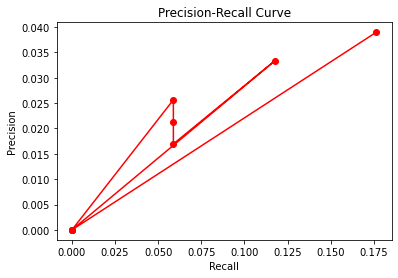

In [57]:
#Plot Precision-Recall curve
import matplotlib.pyplot as plt

# store the precision and recall values in lists
precision = [p1, p2, p3, p4, p5, p6, p7, p8, p9]
recall = [r1, r2, r3, r4, r5, r6, r7, r8, r9]

# plot the precision-recall curve
plt.plot(recall, precision, 'ro-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:
# #Compare the FAQs and biwords for ground truth

# from collections import Counter
# from collections import defaultdict

# def get_matching_topics(faqs, biwords):
#     matched_topics = {topic: {subtopic[0]: False for subtopic in subtopics} for topic, subtopics in faqs.items()}
#     for topic, subtopics in faqs.items():
#         for subtopic, count in subtopics:
#             words = subtopic.split()
#             for biword in biwords:
#                 if biword[0] in words or (biword[0], biword[1]) in words:
#                     matched_topics[topic][subtopic] = True
#                     break
#     return matched_topics

In [ ]:
# ground_truth = get_matching_topics(FAQ_biwords, bigramList)

In [ ]:
# test = []
# for i in FAQ_biwords.values():
#   test.append(i)

In [ ]:
# test[1][0][0]

'book chapter'

In [ ]:
# def get_matching_topics(faqs, biwords):
#   comparator = []
#   for i in faqs.values():
#     comparator.append(i)
  
#   faqSubTopics = []
#   for i in comparator:
#     faqSubTopics.append(comparator[1][0][0])

#     return matched_topics

In [ ]:

# import numpy as np
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer
# import tmtoolkit.topicmod.evaluate as tm_eval
# import gensim

# def runLDA(documents,n_topics, n_words_per_topic, max_features=1000, stop_words='english'):
#     """ Performs LDA topic modeling and return resulting topics as strings in topicList """
#     # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
#     tf_vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
#     tf = tf_vectorizer.fit_transform(documents)
#     tf_feature_names = tf_vectorizer.get_feature_names()

#     # Fit the LDA model
#     lda_model = LatentDirichletAllocation(n_topics, max_iter=50, learning_method='online',
#                                     learning_decay = 0.7,
#                                     learning_offset=50.,
#                                     random_state=0)
#     lda_fit = lda_model.fit(tf)

#     lda_output = lda_model.transform(tf)

#     fileName = "LDA_"+"_"+str(n_topics)+"topics_"+str(n_words_per_topic)+"words.txt"
#     topicList = write_file_top_words(lda_fit, tf_feature_names, n_words_per_topic, fileName)
#     return topicList, lda_model, tf_feature_names, n_topics

In [ ]:
# prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
#              '\n(For example: "wholeChatsFile.txt"):'
# fileName = getFileName(prompt)
# chats = readChatCorpusFile(fileName)
# n_top = 12
# n_wpTop = 9
# topicList, lda_model, tf_names, n_top = runLDA(chats, n_top, n_wpTop)

KeyboardInterrupt: ignored

In [ ]:
#OLD

# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# lemmatizer = WordNetLemmatizer()

# def tokenizeLemmaChats(chats):
#   tokens = []
#   for doc in chats:
#     words = word_tokenize(doc)
#     lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in words]
#     tokens.append(lemmas)
#     return tokens

In [ ]:
# chatTokLem = tokenizeLemmaChats(chats)

In [ ]:
# from gensim.utils import simple_preprocess
# from smart_open import smart_open

# class BoWCorpus(object):
#   def __init__(self, path, dictionary):
#     self.filepath = path
#     self.dictionary = dictionary

#   def __iter__(self):
#     #global mydict  # OPTIONAL, only if updating the source dictionary.
#     for line in smart_open(self.filepath, encoding='latin'):
#         # tokenize
#         tokenized_list = simple_preprocess(line, deacc=True)

#         # create bag of words
#         bow = self.dictionary.doc2bow(tokenized_list, allow_update=True)

#         # update the source dictionary (OPTIONAL)
#         # mydict.merge_with(self.dictionary)

#         # lazy return the BoW
#         yield bow

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import nltk
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from smart_open import smart_open
import os
import numpy as np

#TODO: Play with n_words_perTopics

#def calc_Coherence_Perplexity_LDA(lda_model, topicList, documents, tf_feature_names, n_topics, path = '/content/wholeChatsFile.txt', max_features=1000):

def calc_Coherence_Perplexity_LDA(documents, n_topics, n_words, max_features=1000):

    gensim_dictionary = gensim.corpora.Dictionary(documents)

    # gensim_dictionary = corpora.Dictionary(simple_preprocess(line, deacc=True) for line in open(path, encoding='utf-8'))

    gensim_corpus = [gensim_dictionary.doc2bow(d) for d in documents]

    # gensim_corpus = BoWCorpus(path, dictionary=gensim_dictionary)  # memory friendly

    gensim_model = LdaModel(corpus=gensim_corpus, num_topics=n_topics, id2word=gensim_dictionary, passes = 10, iterations = 10000)

    #  Calculate coherence and Perplexity

    # topicsTok = []

    # for i in topicList:
    #   tokens = word_tokenize(i)
    #   topicsTok.append(tokens)


    # Compute coherence score
    coherence_model = CoherenceModel(model=gensim_model, texts=documents, dictionary=gensim_dictionary, coherence='c_v')
    with np.errstate(invalid='ignore'):
      coherence = coherence_model.get_coherence()
    perplexity = gensim_model.log_perplexity(gensim_corpus)

    #Use the below line for the probabilities, otherwise use show because the output is more coherent
    #topics_gensim = gensim_model.print_topics(n_topics, n_words)
    topics_gensim = gensim_model.show_topics(n_topics, n_words, formatted=False)
    
    return coherence, perplexity, topics_gensim

In [ ]:
coherence, perplexity, topicsGen = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 2, n_words = 10)

In [ ]:
coherence

0.4945800217027073

In [ ]:
perplexity

-6.645563955476622

In [ ]:
topicsGen

[(0,
  [('book', 0.046061315),
   ('check', 0.025524119),
   ('today', 0.016347742),
   ('day', 0.01462913),
   ('request', 0.013694319),
   ('student', 0.010867529),
   ('number', 0.010859001),
   ('ill', 0.010812952),
   ('room', 0.010620973),
   ('desk', 0.010273533)]),
 (1,
  [('find', 0.031559505),
   ('search', 0.024890846),
   ('access', 0.019724177),
   ('link', 0.018580798),
   ('article', 0.018224698),
   ('research', 0.013437855),
   ('database', 0.012944178),
   ('journal', 0.0115894545),
   ('librarian', 0.010955369),
   ('moment', 0.008600899)])]

In [ ]:
for topic in topicsGen:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | check | today | day | request | student | number | ill | room | desk
Topic 1: find | search | access | link | article | research | database | journal | librarian | moment


In [ ]:
coherence1, perplexity1, topicsGen1 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 2, n_words = 10)
coherence2, perplexity2, topicsGen2 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 4, n_words = 10)
coherence3, perplexity3, topicsGen3 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 8, n_words = 10)
coherence4, perplexity4, topicsGen4 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 10, n_words = 10)

In [ ]:
coherence5, perplexity5, topicsGen5 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 12, n_words = 10)
coherence6, perplexity6, topicsGen6 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 13, n_words = 10)
coherence7, perplexity7, topicsGen7 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 14, n_words = 10)
coherence8, perplexity8, topicsGen8 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 15, n_words = 10)
coherence9, perplexity9, topicsGen9 = calc_Coherence_Perplexity_LDA(documents = chatTokens, n_topics = 16, n_words = 10)

In [ ]:
coherence1

0.49233178498913976

In [ ]:
coherence2

0.4966532529789249

In [ ]:
coherence3

0.5088199372365348

In [ ]:
coherence4

0.5311756408486409

In [ ]:
coherence5

0.4830011353671379

In [ ]:
coherence6

0.5085285844284393

In [ ]:
coherence7

0.5088875958667101

In [ ]:
coherence8

0.48476064196096075

In [ ]:
coherence9

0.5228223867893844

In [ ]:
perplexity1

-6.647803983755663

In [ ]:
perplexity2

-6.61573328631726

In [ ]:
perplexity3

-6.62381056959145

In [ ]:
perplexity4

-6.6232477826567

In [ ]:
perplexity5

-6.647855329771975

In [ ]:
perplexity6

-6.640840523948494

In [ ]:
perplexity7

-6.635662821135406

In [ ]:
perplexity8

-6.631224820823607

In [ ]:
perplexity9

-6.633115106162668

In [ ]:
for topic in topicsGen1:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: find | search | access | article | link | research | database | journal | librarian | moment
Topic 1: book | check | today | day | request | student | room | ill | number | desk


In [ ]:
for topic in topicsGen2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: floor | check | uni | collection | print | desk | computer | today | located | number
Topic 1: search | access | link | find | article | database | click | journal | uni | website
Topic 2: book | check | request | today | room | loan | day | reserve | interlibrary | student
Topic 3: find | book | research | librarian | moment | ill | article | link | check | finding


In [ ]:
for topic in topicsGen3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | check | find | number | renew | today | online | call | checked | day
Topic 1: ill | answer | check | place | shortly | citation | author | question | cite | apa
Topic 2: research | librarian | find | paper | database | good | source | finding | email | contact
Topic 3: desk | check | floor | print | computer | laptop | student | day | today | service
Topic 4: search | find | article | journal | database | reviewed | topic | google | peer | bar
Topic 5: room | click | reserve | link | log | account | sign | study | login | medium
Topic 6: access | link | uni | find | student | online | full | moment | campus | journal
Topic 7: request | loan | interlibrary | today | day | open | hour | ill | check | week


In [ ]:
for topic in topicsGen4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | request | check | find | loan | ill | interlibrary | online | place | answer
Topic 1: search | find | article | journal | database | topic | link | google | specific | reviewed
Topic 2: access | link | uni | click | campus | log | online | database | student | account
Topic 3: print | computer | printer | color | pdf | printing | copy | link | instruction | black
Topic 4: citation | question | author | cite | apa | reference | nan | sociology | website | answer
Topic 5: check | student | renew | today | book | day | number | contact | uni | email
Topic 6: research | librarian | paper | source | appointment | finding | time | question | good | set
Topic 7: open | today | hour | art | day | music | tomorrow | visitor | good | closed
Topic 8: find | email | moment | class | student | librarian | contact | question | professor | read
Topic 9: room | reserve | desk | floor | check | laptop | today | day | medium | hour


In [ ]:
for topic in topicsGen5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: room | reserve | computer | print | study | nan | reserved | day | reservation | scheduler
Topic 1: research | librarian | paper | question | ill | test | chat | answer | reference | consultation
Topic 2: access | link | click | find | uni | campus | log | request | online | full
Topic 3: book | find | request | check | ill | loan | number | interlibrary | moment | copy
Topic 4: book | check | renew | checked | today | online | item | student | week | day
Topic 5: find | article | journal | link | google | review | attached | topic | specific | moment
Topic 6: search | article | find | database | reviewed | bar | peer | topic | website | type
Topic 7: librarian | email | contact | good | find | source | moment | research | question | time
Topic 8: check | laptop | citation | cite | apa | card | hey | website | visitor | author
Topic 9: open | today | hour | day | check | medium | digital | special | number | contact
Topic 10: student | uni | access | campus | university | scho

In [ ]:
for topic in topicsGen6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: copy | patron | map | physical | adobe | activity | april | version | fiction | wednesday
Topic 1: find | access | journal | full | google | online | link | article | scholar | text
Topic 2: attached | test | anne | eric | trouble | marie | praxis | play | ebsco | finding
Topic 3: search | article | find | reviewed | peer | bar | print | topic | type | journal
Topic 4: ill | citation | question | find | link | time | moment | dr | reference | apa
Topic 5: check | answer | place | ill | shortly | question | day | card | nan | desk
Topic 6: book | request | loan | interlibrary | renew | today | checked | day | check | youth
Topic 7: room | reserve | check | today | hour | open | desk | day | time | medium
Topic 8: contact | email | computer | student | laptop | special | uni | collection | school | number
Topic 9: book | find | title | moment | online | check | number | search | author | specific
Topic 10: floor | located | uni | student | art | number | desk | call | music | ma

In [ ]:
for topic in topicsGen7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: student | class | course | find | professor | dr | chapter | reserve | read | hold
Topic 1: request | loan | interlibrary | link | ill | book | library | day | form | click
Topic 2: book | check | number | renew | find | today | floor | call | day | checked
Topic 3: librarian | research | email | contact | paper | question | good | source | appointment | find
Topic 4: dissertation | list | business | find | thesis | guide | work | member | department | site
Topic 5: journal | attached | review | ’ | find | science | moment | article | title | magazine
Topic 6: check | answer | place | ill | shortly | desk | print | question | computer | laptop
Topic 7: access | online | database | link | full | find | text | uni | moment | student
Topic 8: find | collection | special | citation | author | link | moment | iowa | contact | website
Topic 9: room | reserve | study | nan | reserved | camera | group | day | reservation | people
Topic 10: search | find | article | database | topic | 

In [ ]:
for topic in topicsGen8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | check | hold | request | online | student | find | pick | moment | title
Topic 1: search | click | find | link | bar | side | website | option | homepage | left
Topic 2: student | uni | staff | member | video | check | faculty | dr | dvd | card
Topic 3: access | link | uni | campus | database | student | work | log | full | find
Topic 4: answer | ill | place | check | shortly | question | citation | link | author | cite
Topic 5: request | loan | interlibrary | journal | access | link | copy | find | online | full
Topic 6: floor | find | located | number | call | desk | main | uni | section | stack
Topic 7: article | research | find | search | topic | database | reviewed | peer | journal | finding
Topic 8: librarian | find | contact | email | moment | good | research | going | time | chat
Topic 9: today | check | open | hour | day | time | week | tomorrow | good | service
Topic 10: renew | book | account | checked | item | number | today | online | woman | day
Topic 11: 

In [ ]:
for topic in topicsGen9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: link | work | computer | campus | issue | download | website | pdf | problem | moment
Topic 1: search | click | reviewed | peer | side | find | link | left | hand | option
Topic 2: room | reserve | study | medium | digital | hub | reserved | group | reservation | scheduler
Topic 3: journal | find | research | database | good | specific | education | academic | topic | article
Topic 4: floor | desk | check | number | call | located | item | student | today | uni
Topic 5: search | article | find | google | scholar | attached | bar | specific | website | searching
Topic 6: database | search | list | test | data | anne | chat | box | website | literature
Topic 7: book | online | check | renew | find | copy | checked | title | youth | moment
Topic 8: request | loan | interlibrary | link | access | full | find | ill | text | moment
Topic 9: today | check | open | hour | day | time | good | tomorrow | laptop | long
Topic 10: print | printer | color | printing | document | cost | blac

In [ ]:
coherenceBi, perplexityBi, topicsGenBi = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 2, n_words = 10)

In [ ]:
coherenceBi

0.2646745007629311

In [ ]:
perplexityBi

-8.18003025505338

In [ ]:
for topic in topicsGenBi:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 1: interlibrary loan | place answer | check place | ill shortly | google scholar | full text | answer ill | search bar | today day | find book


In [ ]:
coherenceBi2, perplexityBi2, topicsGenBi2 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 4, n_words = 10)

In [ ]:
coherenceBi2

0.26422378503904276

In [ ]:
perplexityBi2

-8.207423375885272

In [ ]:
for topic in topicsGenBi2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: interlibrary loan | check place | answer ill | place answer | ill shortly | google scholar | full text | today day | search bar | find book
Topic 1: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 2: check place | interlibrary loan | ill shortly | answer ill | today day | search bar | google scholar | peer reviewed | answer question | full text
Topic 3: check place | place answer | interlibrary loan | answer ill | ill shortly | search bar | google scholar | peer reviewed | answer question | today day


In [ ]:
coherenceBi3, perplexityBi3, topicsGenBi3 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 8, n_words = 10)

In [ ]:
coherenceBi3

0.2719087950764333

In [ ]:
perplexityBi3

-8.231622433498828

In [ ]:
for topic in topicsGenBi3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: check place | interlibrary loan | answer ill | place answer | ill shortly | google scholar | full text | answer question | today day | peer reviewed
Topic 1: interlibrary loan | answer ill | check place | ill shortly | place answer | google scholar | search bar | answer question | today day | full text
Topic 2: place answer | interlibrary loan | ill shortly | answer ill | search bar | check place | google scholar | full text | answer question | today day
Topic 3: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 4: interlibrary loan | check place | google scholar | place answer | ill shortly | full text | answer ill | peer reviewed | search bar | answer question
Topic 5: interlibrary loan | check place | answer ill | place answer | google scholar | ill shortly | full text | today day | peer reviewed | answer question
Topic 6: today day | check place | peer reviewed | search bar 

In [ ]:
coherenceBi4, perplexityBi4, topicsGenBi4 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 10, n_words = 10)

In [ ]:
coherenceBi4

0.4355061257994354

In [ ]:
perplexityBi4

-8.248575256996354

In [ ]:
for topic in topicsGenBi4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: interlibrary loan | place answer | check place | google scholar | ill shortly | answer ill | search bar | full text | today day | answer question
Topic 1: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 2: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 3: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 4: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 5: interlibrary loan | place answer | check place | answer ill | ill shortly | search bar | google scholar | peer reviewed | answer question | call number
Topic 6: 

In [ ]:
coherenceBi5, perplexityBi5, topicsGenBi5 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 12, n_words = 10)

In [ ]:
coherenceBi5

0.37390085232193426

In [ ]:
perplexityBi5

-8.253067539333117

In [ ]:
for topic in topicsGenBi5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: place answer | ill shortly | interlibrary loan | google scholar | check place | answer ill | full text | peer reviewed | special collection | answer question
Topic 1: interlibrary loan | answer ill | place answer | check place | search bar | ill shortly | google scholar | today day | peer reviewed | full text
Topic 2: check place | place answer | ill shortly | answer ill | google scholar | interlibrary loan | today day | full text | find book | search bar
Topic 3: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 4: interlibrary loan | ill shortly | answer ill | check place | place answer | today day | search bar | google scholar | full text | answer question
Topic 5: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 6: private room | private employer | proble

In [ ]:
coherenceBi6, perplexityBi6, topicsGenBi6 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 13, n_words = 10)

In [ ]:
coherenceBi6

0.464140674974102

In [ ]:
perplexityBi6

-8.259679657639628

In [ ]:
for topic in topicsGenBi6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 1: interlibrary loan | place answer | check place | ill shortly | answer ill | search bar | google scholar | today day | answer question | call number
Topic 2: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 3: interlibrary loan | ill shortly | answer ill | check place | full text | place answer | google scholar | search bar | peer reviewed | today day
Topic 4: place answer | interlibrary loan | ill shortly | answer ill | google scholar | search bar | check place | peer reviewed | today day | special collection
Topic 5: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 6: private room | pri

In [ ]:
coherenceBi7, perplexityBi7, topicsGenBi7 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 14, n_words = 10)

In [ ]:
coherenceBi7

0.4480694933171136

In [ ]:
perplexityBi7

-8.267977698507968

In [ ]:
for topic in topicsGenBi7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: ill shortly | place answer | check place | interlibrary loan | answer ill | peer reviewed | google scholar | full text | search bar | today day
Topic 1: place answer | interlibrary loan | answer ill | ill shortly | check place | google scholar | peer reviewed | search bar | today day | find book
Topic 2: interlibrary loan | check place | ill shortly | place answer | google scholar | search bar | today day | answer ill | peer reviewed | find book
Topic 3: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | today day
Topic 4: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 5: interlibrary loan | check place | answer ill | place answer | ill shortly | google scholar | search bar | answer question | full text | call number
Topic 6: private room | private employer | problem campus

In [ ]:
coherenceBi8, perplexityBi8, topicsGenBi8 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 15, n_words = 10)

In [ ]:
coherenceBi8

0.46468028682056395

In [ ]:
perplexityBi8

-8.267056447376198

In [ ]:
for topic in topicsGenBi8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 1: check place | google scholar | answer ill | interlibrary loan | ill shortly | place answer | today day | search bar | full text | answer question
Topic 2: interlibrary loan | ill shortly | check place | place answer | answer ill | today day | answer question | google scholar | search bar | peer reviewed
Topic 3: answer ill | check place | interlibrary loan | ill shortly | search bar | place answer | peer reviewed | google scholar | today day | full text
Topic 4: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 5: place answer | interlibrary loan | check place | ill shortly | answer ill | search bar | answer question | peer reviewed | call number | google scholar
Topic 6: private room | 

In [ ]:
coherenceBi9, perplexityBi9, topicsGenBi9 = calc_Coherence_Perplexity_LDA(documents = bigrams, n_topics = 16, n_words = 10)

In [ ]:
coherenceBi9

0.5310618293581354

In [ ]:
perplexityBi9

-8.29219978201549

In [ ]:
for topic in topicsGenBi9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 1: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 2: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 3: private room | private employer | problem campus | problem book | problem attached | problem assist | problem alright | problem accessing | problem access | pro con
Topic 4: interlibrary loan | place answer | check place | ill shortly | google scholar | answer ill | peer reviewed | full text | today day | answer question
Topic 5: interlibrary loan | check place | ill shortly | place answer | answer ill | google scholar | search bar | peer reviewed | full text | tod

In [ ]:
#Imports for PyMallet
!pip install gensim nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Get the Mallet distro

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2023-03-03 14:58:53--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-03-03 14:58:53--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  60.8MB/s    in 0.3s    

2023-03-03 14:58:53 (60.8 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
#Put distro in folder

import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8/bin'

In [ ]:
!pip install pymallet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.0/148.0 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymallet: filename=pymallet-0.1.1-py3-none-any.whl size=4799 sha256=116823e5f4c5300c2b4075a1823f7cba2030e0a4942ccbabc87fc407001aa675
  Stored in directory: /root/.cache/pip/wheels/48/97/a5/95a583063821b54052682b2837975e84f75d22bb462174e1cc
Successfully built pymallet


In [ ]:
#PymalletLDA
import gensim
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

def PyMalletLDA(documentsTokens, n_topics, n_words):
    # Import Tokens, then create the Gensim dictionary
    dictionary = Dictionary(documentsTokens)

    # Bag of words representation
    corpus = [dictionary.doc2bow(doc) for doc in documentsTokens]

    # PyMallet LDA model using the MALLET Binaries
    mallet_path = '/content/mallet-2.0.8/bin/mallet'  # Set the path to the Mallet binary
    lda_mallet = LdaMallet(mallet_path, corpus=corpus, num_topics=n_topics, id2word=dictionary)

    # Convert the Mallet LDA model to a Gensim LdaModel
    gensim_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

    # Topics
    topics = gensim_model.show_topics(num_topics=n_topics, num_words=n_words, formatted=False)

    # Coherence and Perplexity
    coherence_model_ldamallet = CoherenceModel(model=gensim_model, texts=documentsTokens, dictionary=dictionary, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()

    perplexity_ldamallet = gensim_model.log_perplexity(corpus)

    return coherence_ldamallet, perplexity_ldamallet, topics

In [ ]:
coherence, perplexity, topics = PyMalletLDA(documentsTokens = chatTokens, n_topics = 2, n_words = 10)

In [ ]:
coherence

0.7404158069198237

In [ ]:
perplexity

-8.591899681210244

In [ ]:
for topic in topics:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: happened | nvm | notice | nearby | cover | place | processing | copyright | confusing | controversial
Topic 1: baby | photocopy | tlc | quick | temperature | rule | greek | rm | day | rented


In [ ]:
coherence1, perplexity1, topics1 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 2, n_words = 10)
coherence2, perplexity2, topics2 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 4, n_words = 10)
coherence3, perplexity3, topics3 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 8, n_words = 10)
coherence4, perplexity4, topics4 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 10, n_words = 10)
coherence5, perplexity5, topics5 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 12, n_words = 10)
coherence6, perplexity6, topics6 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 13, n_words = 10)
coherence7, perplexity7, topics7 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 14, n_words = 10)
coherence8, perplexity8, topics8 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 15, n_words = 10)
coherence9, perplexity9, topics9 = PyMalletLDA(documentsTokens = chatTokens, n_topics = 16, n_words = 10)

In [ ]:
#Using the n-grams

coherence1, perplexity1, topics1 = PyMalletLDA(documentsTokens = unigrams, n_topics = 2, n_words = 10)
coherence2, perplexity2, topics2 = PyMalletLDA(documentsTokens = unigrams, n_topics = 4, n_words = 10)
coherence3, perplexity3, topics3 = PyMalletLDA(documentsTokens = unigrams, n_topics = 8, n_words = 10)
coherence4, perplexity4, topics4 = PyMalletLDA(documentsTokens = unigrams, n_topics = 10, n_words = 10)
coherence5, perplexity5, topics5 = PyMalletLDA(documentsTokens = unigrams, n_topics = 12, n_words = 10)
coherence6, perplexity6, topics6 = PyMalletLDA(documentsTokens = unigrams, n_topics = 13, n_words = 10)
coherence7, perplexity7, topics7 = PyMalletLDA(documentsTokens = unigrams, n_topics = 14, n_words = 10)
coherence8, perplexity8, topics8 = PyMalletLDA(documentsTokens = unigrams, n_topics = 15, n_words = 10)
coherence9, perplexity9, topics9 = PyMalletLDA(documentsTokens = unigrams, n_topics = 16, n_words = 10)

In [ ]:
coherence1

0.5926354221489296

In [ ]:
perplexity1

-8.560455640441104

In [ ]:
for topic in topics1:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: number | firearm | sit | copied | difference | turn | majority | renewal | latin | charged
Topic 1: archive | politics | player | students’ | nursing | permalinks | reply | hat | lgbtq | classmate


In [ ]:
coherence2

0.5973408265935056

In [ ]:
perplexity2

-8.668217081305983

In [ ]:
for topic in topics2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: psychologist | greek | rao | engagement | forwarded | camera | satisfaction | declaration | angelauni | cornerstone
Topic 1: distribution | killer | university | butt | taught | persuasive | richard | question | tim | roster
Topic 2: loomis | basic | night | jan | disability | map | accessing | interlibrary | ipad | entirety
Topic 3: yep | spent | legacy | bilingual | sooner | decide | behavioral | camp | based | happen


In [ ]:
coherence3

0.6568621140405464

In [ ]:
perplexity3

-8.795664099264023

In [ ]:
for topic in topics3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: article | daytime | max | solved | brand | southeast | teach | bless | matisse | affirmative
Topic 1: fella | interview | racial | ibis | libguide | certificate | named | car | agenda | poster
Topic 2: weekday | fort | text | embargo | viewpoint | guest | premium | tricky | digitally | anytime
Topic 3: university | exit | calendar | terrorism | liasion | pedagogy | site | fourth | amg | homer
Topic 4: organizational | bias | logo | freedom | scientific | tree | follow | psychologist | instance | simple
Topic 5: doctorate | latin | assistant | ecological | participation | stuck | index | category | protection | guadalupe
Topic 6: mae | harassment | restarting | europe | wendy | paradox | word | york | psychinfo | industry
Topic 7: stephen | zip | fine | send | covered | anthology | mode | saturday | prep | folk


In [ ]:
coherence4

0.6667174593038317

In [ ]:
perplexity4

-8.860073645765047

In [ ]:
for topic in topics4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: pulling | assessment | madison | guarantee | nexis | faculty | criticism | length | prediction | monitor
Topic 1: frank | intelligence | downloaded | coursework | googled | silent | limited | inconvenience | hickey | raising
Topic 2: specific | percentage | waterloo | instructor | belief | fast | spent | ohio | knew | loading
Topic 3: acceptance | released | conflict | american | girl | agency | produced | empirical | alternative | personal
Topic 4: organisational | clarification | identifier | contemporary | meany | ib | couple | push | god | screenshot
Topic 5: moines | ii | implicit | position | submitted | researched | craig | computer | thread | coursework
Topic 6: request | awesome | nicholas | involves | advertising | assessing | bulletin | includes | finding | endnote
Topic 7: spiritual | assistant | employment | stay | homeless | hmmm | span | extremely | washington | chronicle
Topic 8: integration | liaison | nah | smoking | daughter | davis | economics | deeper | ha

In [ ]:
coherence5

0.6419979573349576

In [ ]:
perplexity5

-8.920224111582113

In [ ]:
for topic in topics5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: enjoy | booth | cynthia | charles | eastern | limiter | exercise | phone | user | volume
Topic 1: wave | campus | knowledge | statistical | hear | retrieve | year | intelligence | spiritual | digitally
Topic 2: three | friend | disability | andor | germany | visiting | greeting | stick | relate | kenneth
Topic 3: bib | fund | connection | sue | pablo | pickup | autocad | henry | indicate | international
Topic 4: working | essence | communist | bullying | rapid | phone | biology | problemo | kanopy | fox
Topic 5: portal | mode | appears | clarification | december | hm | unable | descriptive | success | ana
Topic 6: confidence | mom | played | remembered | psychlogical | chatting | communication | restricted | land | craft
Topic 7: program | meeting | reflection | profession | bitrodlibill | reviewed | gettysburg | med | wing | cross
Topic 8: tutorial | residence | sebo | resistance | recognize | publication | soviet | info | locate | philip
Topic 9: illiad | capacity | gonna | 

In [ ]:
coherence6

0.6604150260264685

In [ ]:
perplexity6

-8.951064043959855

In [ ]:
for topic in topics6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: ebrary | base | god | extra | quotation | associate | theme | owns | shop | cotton
Topic 1: myuniverse | stress | company | lang | impact | phonological | seerley | word | recheck | webinars
Topic 2: response | seminar | demonstrating | jungle | hadnt | reasoning | appointment | passage | deaf | pc
Topic 3: newsweek | inequality | psychological | tent | public | bug | assigned | diversity | fred | libarys
Topic 4: indepth | webbebscohostproxyuni | disc | concert | mine | describe | academy | principal | disorganization | artwork
Topic 5: mark | liason | waterloo | physically | doc | kindergarten | coming | claire | step | ahead
Topic 6: ighsau | guessing | ii | harlem | anytime | proquest | regulation | messaged | normal | isbn
Topic 7: wedding | editorial | slip | gailbunzuni | expecting | reach | treatment | magic | meeting | communist
Topic 8: conducting | feasibility | today | kate | edgington | out | category | younger | speech | continues
Topic 9: apply | chicago | wheel

In [ ]:
coherence7

0.6278250908551041

In [ ]:
perplexity7

-8.984554777498776

In [ ]:
for topic in topics7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: unsure | heritage | parenthesis | nov | california | story | alphabetically | inclusion | tool | topic
Topic 1: scientist | thx | easier | house | source | surrounding | foreign | preference | hand | pablo
Topic 2: involves | claudia | assault | definition | concerned | employment | reconnect | laminator | videatives | affair
Topic 3: advantage | lol | vending | dale | base | europe | encourage | natural | tree | bigger
Topic 4: paying | prison | actress | physically | awhile | cut | way | participation | majority | lesbian
Topic 5: interpreting | faulkner | utilize | good | adventure | comfortable | publishing | eye | council | hockey
Topic 6: demand | developmental | apartment | copier | smart | utilize | learned | sing | microwave | accidently
Topic 7: sun | processed | james | afternoon | childrens | formula | curriculum | jr | outlet | experimental
Topic 8: exchange | iron | recycling | recommended | illinois | tag | automatically | sustainability | maria | variation
Topi

In [ ]:
coherence8

0.6335494497871913

In [ ]:
perplexity8

-9.013811578253645

In [ ]:
for topic in topics8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: innovative | advocacy | reverse | accounting | apsac | relevant | preview | misunderstood | scanned | agriculture
Topic 1: um | deaf | expected | right | location | van | dress | excellent | physically | athens
Topic 2: thesis | coverage | dropdown | hdmi | advance | guessing | guadalupe | reasoning | patience | bad
Topic 3: linking | wave | south | yellow | cool | hypothetical | state | scholarworks | assume | obvious
Topic 4: machine | diverse | screenshot | export | book | grandfather | house | grant | framework | google
Topic 5: online | kic | marital | image | notified | victim | screening | winner | coordinator | popped
Topic 6: effort | animal | love | cited | blocked | case | girl | fund | convenient | force
Topic 7: albertsons | basketball | sickle | aid | misunderstood | special | web | smaller | roughly | ellen
Topic 8: creative | pc | head | showing | pharmacy | result | senior | rick | guy | check
Topic 9: told | kicked | wuz | virtue | stan | panther | leadership

In [ ]:
coherence9

0.6449682136008025

In [ ]:
perplexity9

-9.048291903845707

In [ ]:
for topic in topics9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: named | path | characteristic | dating | firefox | note | robyn | attending | grade | tested
Topic 1: scultpure | accession | indepth | outstanding | limited | collect | halloween | michelle | maria | sondering
Topic 2: collection | upton | comment | realize | william | plug | winter | safari | lack | move
Topic 3: upstairs | onenote | dated | finishing | scultpure | liasion | wire | esg | yall | clock
Topic 4: satisfaction | notice | pas | row | racism | street | amazon | chance | host | instructional
Topic 5: mailing | representation” | offer | claim | alum | happened | randomly | influence | dissertation | face
Topic 6: traumatic | learner | lawrence | talked | kicked | matter | closest | arkansas | common | cyber
Topic 7: upton | theme | legacy | develop | tablet | official | alright | tree | hurry | okie
Topic 8: darn | limitation | skating | wifi | fax | framework | unsure | analyze | tribe | africa
Topic 9: philosophy | politics | depression | night | idk | subscribed |

In [ ]:
coherenceBim, perplexityBim, topicsBim = PyMalletLDA(documentsTokens = bigrams, n_topics = 2, n_words = 10)

In [ ]:
coherenceBim

0.7070140146100652

In [ ]:
perplexityBim

-9.068295696164373

In [ ]:
for topic in topicsBim:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: article good | long open | articlejournal search | reason disconnected | email professor | reserve scholar | bound periodical | primary secondary | email check | year ago
Topic 1: oversees room | librarian today | grinning face | ticket librarian | link google | alex plant | search result | online version | night search | exact title


In [ ]:
coherenceBim2, perplexityBim2, topicsBim2 = PyMalletLDA(documentsTokens = bigrams, n_topics = 4, n_words = 10)

In [ ]:
coherenceBim2

0.6757192543678582

In [ ]:
perplexityBim2

-9.27144419944014

In [ ]:
for topic in topicsBim2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: search top | renew material | doug shaw | good check | youth service | book coming | long check | research study | business day | fall class
Topic 1: database childrens | problem night | student print | list list | good option | “readingrockets video | electronic access | hub closed | longer student | currently research
Topic 2: yeah moment | onesearch advanced | thing search | criticism online | side log | article student | uni webpage | librarian search | book good | access resource
Topic 3: student view | final week | shelf book | search university | table content | scholar google | click google | link purdue | connected uni | located located


In [ ]:
coherenceBim3, perplexityBim3, topicsBim3 = PyMalletLDA(documentsTokens = bigrams, n_topics = 8, n_words = 10)

In [ ]:
coherenceBim3

0.693385963124798

In [ ]:
perplexityBim3

-9.693526562480676

In [ ]:
for topic in topicsBim3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: access title | degree il | number title | student ill | find article | attached ill | technology software | call desk | language literature | class assignment
Topic 1: submit job | find three | link help | language art | compact periodical | previous chat | checkout period | online journal | article subject | early tomorrow
Topic 2: whats title | community college | moment transfer | find environmental | database article | search work | second search | link library | number alright | monday friday
Topic 3: loan access | pro con | meet librarian | copy link | article pop | recommend going | email problem | moment figure | find poem | question book
Topic 4: pdf email | book long | student free | desk moment | web link | link schedule | space reserved | keep chat | attached second | helpful day
Topic 5: question citing | database button | computer print | find loan | search history | find eric | click sign | student alumnus | loan access | ready picked
Topic 6: latin american | t

In [ ]:
coherenceBim4, perplexityBim4, topicsBim4 = PyMalletLDA(documentsTokens = bigrams, n_topics = 10, n_words = 10)

In [ ]:
coherenceBim4

0.6894062551817659

In [ ]:
perplexityBim4

-9.930975709462485

In [ ]:
for topic in topicsBim4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: paper specific | southeast iowa | link list | catalog click | white printer | quotation mark | click icon | journal trouble | expository book | online material
Topic 1: currently student | final week | link purdue | student download | grinning face | finding book | access today | search searched | bar option | book call
Topic 2: check problem | clicked findit | ill office | ill forward | login gain | good book | day figure | reserve request | online article | proquest dissertation
Topic 3: print select | active learning | book teaching | carolyn hildebrandt | article librarian | book return | happy find | accessing database | north american | citing citation
Topic 4: second book | research find | technology service | today article | log ebsco | number listed | full title | book pulled | campus search | librarian going
Topic 5: check service | firearm ownership | email rosemary | website catid | young adult | request request | policy study | checked hour | homer seerley | desk 

In [ ]:
coherenceBim5, perplexityBim5, topicsBim5 = PyMalletLDA(documentsTokens = bigrams, n_topics = 12, n_words = 10)

In [ ]:
coherenceBim5

0.6803251582720654

In [ ]:
perplexityBim5

-10.18891074130577

In [ ]:
for topic in topicsBim5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: collection email | lot people | email problem | hawk county | desk question | snowball sampling | better assist | finding study | email libarchivesuni | support animal
Topic 1: problem find | research demographic | data set | identity crisis | reserve reserve | search source | checking moment | vos email | article assist | login access
Topic 2: order access | article moment | finding database | search peer | ill alright | court case | book journal | yeah book | located main | print print
Topic 3: student book | request select | sign option | good weekend | check couple | couple way | access kanopy | find relevant | checked moment | day title
Topic 4: problem website | book written | call book | link google | awesome ill | select journal | person charge | night check | tonight open | going forward
Topic 5: desk send | side building | article example | email directly | check title | room today | cite paper | link open | check dvd | scheduler reserve
Topic 6: happy meet | thing l

In [ ]:
coherenceBim6, perplexityBim6, topicsBim6 = PyMalletLDA(documentsTokens = bigrams, n_topics = 13, n_words = 10)

In [ ]:
coherenceBim6

0.6937766212404702

In [ ]:
perplexityBim6

-10.323004466048902

In [ ]:
for topic in topicsBim6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: hawkeye community | problem alright | question reference | specific study | checkout moment | reviewed study | check version | email send | article day | access download
Topic 1: gale virtual | viewing room | day open | linked full | childhood special | teen social | limiting access | article pertaining | going search | organizational behavior
Topic 2: group student | access ebooks | face big | log ill | limit print | morning open | abstract full | problem campus | email person | late fee
Topic 3: link find | article issue | degree il | provided link | “miss representation” | reserve reserve | phone email | copy copy | create account | email pick
Topic 4: text article | adlerian theory | book youth | full text | problem database | figure access | title link | desk today | book going | request journal
Topic 5: couple search | homer seerley | drive listen | today trouble | access site | source journal | search click | teacher find | link book | topic interest
Topic 6: scholar go

In [ ]:
coherenceBim7, perplexityBim7, topicsBim7 = PyMalletLDA(documentsTokens = bigrams, n_topics = 14, n_words = 10)

In [ ]:
coherenceBim7

0.6958770382308046

In [ ]:
perplexityBim7

-10.460622710752283

In [ ]:
for topic in topicsBim7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: signed account | manufacturing skill | website check | book click | office number | business communication | request consultation | copy journal | work logged | loan system
Topic 1: bar access | floor plan | history book | thought book | camera digital | open window | webpage click | board game | book website | hey question
Topic 2: desk call | enjoy rest | tomorrow email | day requested | sociology study | article reference | night access | check wait | problem problem | circ desk
Topic 3: monday thursday | specific question | student health | extend book | bound periodical | qualitative study | topic trouble | desk renew | database homepage | good thing
Topic 4: question citing | university website | finding going | time staff | drop menu | opening link | electronic resource | working campus | email question | skating pro
Topic 5: report search | edition book | family service | audio room | copy checked | start article | search time | article assist | book art | wifi hotspot

In [ ]:
coherenceBim8, perplexityBim8, topicsBim8 = PyMalletLDA(documentsTokens = bigrams, n_topics = 15, n_words = 10)

In [ ]:
coherenceBim8

0.6782610495520424

In [ ]:
perplexityBim8

-10.60362462548464

In [ ]:
for topic in topicsBim8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: limit search | nan book | loan ill | problem happy | white bar | today close | find child | alright send | art class | find textbook
Topic 1: attached assignment | shortly check | research day | currently registered | account search | today terrific | campus student | actual research | class article | allen college
Topic 2: reviewed article | data set | submit problem | hotspot check | check ill | renew dvd | option top | listed database | located ittc | request alright
Topic 3: house election | print personal | assault college | topic trouble | located search | accidentally closed | yana tipia | hold minute | room meeting | interested book
Topic 4: issue trend | domestic violence | interested finding | open sunday | chat link | volume journal | find today | time check | typed google | send book
Topic 5: campus campus | room located | needed problem | log ill | survey assignment | close today | database problem | question transferred | section called | lot book
Topic 6: read t

In [ ]:
coherenceBim9, perplexityBim9, topicsBim9 = PyMalletLDA(documentsTokens = bigrams, n_topics = 16, n_words = 10)

In [ ]:
coherenceBim9

0.687541655906028

In [ ]:
perplexityBim9

-10.749422598597025

In [ ]:
for topic in topicsBim9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: copy print | mla format | assisted suicide | item today | request interlibrary | access preview | number floor | quick search | online wanted | pick tomorrow
Topic 1: nice afternoon | mental illness | art education | today campus | request form | read access | today research | idea find | librarian contact | library website
Topic 2: room schedule | recommend starting | shot martha | request complete | primary secondary | collection archive | read tesol | online copy | read access | attached access
Topic 3: leisure service | citing source | link attached | access onesearch | librarian check | watch “readingrockets | history librarian | article question | apsac handbook | side homepage
Topic 4: wage raised | time recommend | today dr | number floor | ill moment | ill copy | engine find | paper topic | reserve access | find better
Topic 5: moment journal | day ill | summer hour | desk send | idea check | time work | check special | wanted find | luck finding | phone today
Topic 6

In [ ]:
import gensim
from gensim import corpora, models
from nltk.corpus import stopwords
import numpy as np
import pandas as pd

def tfidf_lsa(documents, n_topics, n_words, formatted=False):
    # Create dictionary
    dictionary = corpora.Dictionary(documents)

    # Filter out extreme values from dictionary:
    dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=10000)

    # Create corpus
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Compute TF-IDF scores
    tfidf = models.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]

    # Perform LSA
    lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=n_topics)

    # Compute coherence score
    coherence_model = models.CoherenceModel(model=lsi_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    # Show topics
    topics = lsi_model.show_topics(num_topics=n_topics, num_words=n_words, formatted=formatted)

    return coherence_score, topics

In [ ]:
coherence1, topics1 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 2)

In [ ]:
coherence1

0.45579552141671864

In [ ]:
for topic in topics1:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | item | study | second | textbook | website | tonight | click | moment | sign


In [ ]:
coherence2, topics2 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 4)

In [ ]:
coherence2

0.42173735500957743

In [ ]:
for topic in topics2:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | charger | ’ | class | scholarly | issue | pdf | day | cat | phone
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open


In [ ]:
coherence3, topics3 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 8)

In [ ]:
coherence3

0.45010443413661644

In [ ]:
for topic in topics3:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | list | campus | resource | dissertation | sign | hold | account | time | second
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | check | ill | room | book | place | interlibrary
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | loan | room | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack


In [ ]:
coherence4, topics4 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 10)

In [ ]:
coherence4

0.42764895644630563

In [ ]:
for topic in topics4:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | periodical | tomorrow | topic | onesearch | music | specific | hey | click | summer
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | check | ill | room | book | place | interlibrary
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | loan | room | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack
Topic 8: print | open | floor | research | today | hour | access | librarian | color | printer
Topic 9: print | open | reviewed | peer | access | search | loan | hour | interlibrary | research


In [ ]:
coherence5, topics5 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 12)

In [ ]:
coherence5

0.45987439977739886

In [ ]:
for topic in topics5:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | author | study | specific | magazine | circulation | video | catalog | movie | whats
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | ill | check | room | book | place | reviewed
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | loan | room | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack
Topic 8: print | open | floor | research | today | hour | access | librarian | printer | color
Topic 9: print | open | reviewed | peer | access | search | loan | hour | research | interlibrary
Topic 10: open | renew | research | access | hour | libra

In [ ]:
coherence6, topics6 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 13)

In [ ]:
coherence6

0.4018763461284619

In [ ]:
for topic in topics6:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | online | class | dvd | movie | whats | awesome | question | nice | catalog
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | check | ill | room | book | place | reviewed
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | loan | room | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack
Topic 8: print | open | floor | research | today | hour | access | printer | librarian | color
Topic 9: print | open | reviewed | peer | access | search | loan | hour | research | interlibrary
Topic 10: open | renew | research | access | hour | librarian | loa

In [ ]:
coherence7, topics7 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 14)

In [ ]:
coherence7

0.4065854890965814

In [ ]:
for topic in topics7:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | going | work | business | finding | ’ | reserved | irts | item | download
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | ill | check | room | book | place | reviewed
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | loan | room | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack
Topic 8: print | open | floor | research | today | hour | access | librarian | printer | color
Topic 9: print | open | reviewed | peer | access | search | loan | hour | interlibrary | research
Topic 10: open | renew | research | access | hour | loan | librarian

In [ ]:
coherence8, topics8 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 15)

In [ ]:
coherence8

0.42610542220273634

In [ ]:
for topic in topics8:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | fine | history | resource | account | sport | section | borrow | perfect | problem
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | check | ill | room | book | place | reviewed
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | room | loan | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack
Topic 8: print | open | floor | research | today | hour | access | librarian | printer | color
Topic 9: print | open | reviewed | peer | access | search | loan | hour | research | interlibrary
Topic 10: open | renew | research | access | hour | librari

In [ ]:
coherence9, topics9 = tfidf_lsa(chatTokens, n_words = 10, n_topics = 16)

In [ ]:
coherence9

0.3918505159584979

In [ ]:
for topic in topics9:
    print(f'Topic {topic[0]}: {" | ".join([word[0] for word in topic[1]])}')

Topic 0: book | find | search | check | access | link | article | online | today | ill
Topic 1: nan | movie | alright | onesearch | minute | helping | pm | music | option | art
Topic 2: book | renew | article | search | journal | reviewed | peer | database | research | room
Topic 3: room | reserve | book | renew | study | scheduler | hour | reserved | floor | open
Topic 4: renew | search | answer | shortly | check | ill | room | book | place | interlibrary
Topic 5: loan | access | interlibrary | request | check | shortly | answer | floor | renew | place
Topic 6: renew | book | request | interlibrary | loan | room | open | today | reserve | print
Topic 7: renew | floor | shortly | answer | place | ill | check | located | print | stack
Topic 8: print | open | floor | research | today | hour | access | librarian | color | printer
Topic 9: print | open | reviewed | peer | search | access | loan | hour | research | interlibrary
Topic 10: open | renew | research | access | hour | librarian |

In [ ]:
#Install first
#!pip install corextopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#New CorEx
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct

def CorEx(documentTokens, num_topics, seed):
  # Create a CountVectorizer object and fit it on the token lists
  cv = CountVectorizer()
  cv.fit_transform([" ".join(doc) for doc in documentTokens])

  # Create a matrix of token counts
  X = cv.transform([" ".join(doc) for doc in documentTokens]).todense()

  # Create the CorEx topic model
  model = ct.Corex(n_hidden=num_topics, seed=seed)
  model.fit(X)

  # Print the top words for each topic
  topics = model.get_topics()
  for n,topic in enumerate(topics):
      topic_words, *_ = zip(*topic)
      print('{}: '.format(n) + ' | '.join(topic_words))

  # Get document-topic probabilities
  topic_probs = model.transform(X)
  return topic_probs

In [ ]:
topic_probs = CorEx(chatTokens, num_topics = 2, seed = 41)

NOTE: 'words' not provided to CorEx. Returning topics as lists of column indices


TypeError: ignored

In [ ]:
#OLD ONE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def write_PyMallet_LDA(vocabulary, word_topics, n_topics, n_words_per_topic, fileName):
    """ Writes the results of PyMallet LDA to files and returns the resulting topics as
        stings in topicList.
    """
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")
    rawFileName = "raw_"+fileName
    outputFileRaw = open(rawFileName, 'w')
    outputFileRaw.write("File: " + rawFileName +"\n\n")
    topicList = []
    for topic in range(n_topics):
        sorted_words = sorted(vocabulary, key=lambda w: word_topics[w][topic], reverse=True)
        topicStr = " ".join(sorted_words[:n_words_per_topic])
        topicList.append(topicStr)
        outputFile.write(topicStr+"\n")
        outputFileRaw.write(topicStr+"\n")
        #print(topicStr)
        for i in range(n_words_per_topic):
            w = sorted_words[i]
            #print("{}\t{}".format(word_topics[w][topic], w))
            outputFileRaw.write("{}\t{}".format(word_topics[w][topic], w) +"\n")
        
    outputFile.close()
    outputFileRaw.close()
    return topicList

def run_PyMallet_LDA(documents, n_topics, n_words_per_topic, fileNameCorpus=""):
    """ Performs PyMallet LDA topic modeling and return resulting topics as strings in topicList """
    vocabulary, word_topics = PyMallet_LDA(documents, n_topics)
    fileName = "PyMallet_LDA_"+fileNameCorpus+"_"+str(n_topics) \
               +"topics_"+str(n_words_per_topic)+"words.txt"

    topicList = write_PyMallet_LDA(vocabulary, word_topics, n_topics, n_words_per_topic, fileName)

    return topicList
  
prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
             '\n(For example: "wholeChatsFile.txt"):'
fileName = getFileName(prompt)
chats = readChatCorpusFile(fileName)
topicListMallet = run_PyMallet_LDA(chats, 12, 9)

In [ ]:
#topicListMallet

In [ ]:
#OLD ONE!!!!!!!!!!!!!!!!!!!

from gensim.models import lsimodel
from gensim.models import TfidfModel


def run_TFIDF_LSA(documents, n_topics, n_words_per_topic):
    """ Performs TF-IDF and LSA topic modeling and return resulting topics as strings in topicList """
    
    from nltk.corpus import stopwords
    stoplist = set()  # preprocessing removed stop words already...
    dictionary, corpus = createCorpusDictionary(documents, stoplist)
    tfidf = models.TfidfModel(corpus)  # step 1 -- initialize a model

    # Apply a transformation to a whole corpus 
    corpus_tfidf = tfidf[corpus]

    # Initialize an LSI transformation
    numberOfTopics = 2 # (recommended between 200-500)
    lsi = models.LsiModel(corpus_tfidf, id2word = dictionary, num_topics=numberOfTopics)
    #lsi = models.LsiModel(corpus_tfidf, id2word = dictionary)
    # create a double wrapper over chat corpus: bow -> tfidf -> fold-in-lsi
    corpus_lsi = lsi[corpus_tfidf]
    fileName = "TFIDF_LSA_"+str(n_topics)+"topics_"+str(n_words_per_topic)+"words.txt"
    topicList = write_LSA(lsi, n_topics, n_words_per_topic, fileName)
    return topicList, lsi

prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
             '\n(For example: "wholeChatsFile.txt"):'
fileName = getFileName(prompt)
chats = readChatCorpusFile(fileName)
topicListLSA = run_TFIDF_LSA(chats, 12, 9)

In [ ]:
def run_TFIDF_pLSA(documents,n_topics, n_words_per_topic, max_features=1000, stop_words = 'english'):
    """ Performs TF-IDF and pLSA topic modeling and return resulting topics as strings in topicList """
    # Vectorize raw documents to tf-idf matrix: 
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    tfidf = tfidf_vectorizer.fit_transform(documents)

    nmf = NMF(n_components=n_topics, random_state=1,
              beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
              l1_ratio=.5).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()

    fileName = "TFIDF_pLSA_"+str(n_topics)+"topics_"+str(n_words_per_topic)+"words.txt"
    topicList = write_file_top_words(nmf, tfidf_feature_names, n_words_per_topic, fileName)
    return topicList

prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
             '\n(For example: "wholeChatsFile.txt"):'
fileName = getFileName(prompt)
chats = readChatCorpusFile(fileName)
run_TFIDF_pLSA(chats, 12, 9)

In [ ]:
#!pip install corextopic
#!pip install lda

In [ ]:
!pip install corextopic
!pip install lda
!pip show lda

#!pip show lda - shows the path which is /usr/local/lib/python3.8/dist-packages
#For Workaround: Drop the Python Files from GuidedLDA_WorkAround Git Repo in the lda folder

In [ ]:
#P3 utility functions



""" File:  P3_utility_functions.py  

    Description:  Utility functions to performs
    semi-supervised topic modeling utilizing CorEx and GuidedLDA.

    Acknowledgements:

    Here we are used the CorEx (Correlation Explanation) package available at GitHub:
    https://github.com/gregversteeg/corex_topic

    Here we are used the GuidedLDA package is available at GitHub:
    https://github.com/vi3k6i5/GuidedLDA
    NOTE:  We had difficulty installing GuidedLDA, but we were finally successful
    by following the work-around posted at:
    https://github.com/dex314/GuidedLDA_WorkAround

"""
import os.path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from corextopic import corextopic as ct
import pandas as pd
import nltk
from time import time

import re, sys, random, math
import numpy as np
from lda import guidedlda as glda
from lda import glda_datasets as gldad

from collections import Counter
from timeit import default_timer as timer


def readAnchorsFile(fileName):
    """ Reads anchor/seeds from fileName and returns list-of-lists anchorList """
    anchorList = []
    anchorFile = open(fileName, 'r')
    for line in anchorFile:
        wordList = line.strip().split()
        if len(wordList) > 0:
            anchorList.append(wordList)
    anchorFile.close()

    return anchorList

def run_GuidedLDA(chats, anchorList, n_topics, n_words_per_topic,SEED_CONFIDENCE=0.75):
    """ Perform GuidedLDA on corpus from chats using anchorList.
        Returns topics as strings in topicList.
    """
    word2id = {}
    docs = []
    id2word = {}
    wordList = []
    wordId = 0
    for documentLine in chats:
        newDoc = ""
        for word in documentLine.split():
            if word not in word2id:
                word2id[word] = wordId
                id2word[wordId] = word
                wordList.append(word)
                wordId += 1
            newDoc += word + " "
        if len(newDoc) > 0:
            docs.append(newDoc)
    numDocs = len(docs)
    numWords = len(word2id)
    vocab = tuple(wordList)

    X = np.ndarray(shape=(numDocs, numWords), dtype=int)

    word_counts = Counter()
    documents = []
    word_topics = {}
    topic_totals = np.zeros(n_topics)

    for docIndex, docLine in enumerate(docs):
        
        for word in docLine.strip().split():
            wordId = word2id[word]
            X[docIndex][wordId] += 1

    seed_topic_list = anchorList
    model = glda.GuidedLDA(n_topics=n_topics, n_iter=100,
                           random_state=7, refresh=20)
    seed_topics = {}
    for t_id, st in enumerate(seed_topic_list):
        for word in st:
            seed_topics[word2id[word]] = t_id

    model.fit(X, seed_topics=seed_topics, seed_confidence=SEED_CONFIDENCE)

    # Display and write to file the results of CorEx with no anchors
    fileName = "GuidedLDA_seeds_"+str(len(seed_topic_list))+"_confidence_"+ \
               str(SEED_CONFIDENCE)+"_"+str(n_topics) +"topics_"+str(n_words_per_topic)+"words.txt"
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")
    topicList = []
    topic_word = model.topic_word_
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_words_per_topic+1):-1]
        topicStr = '{}'.format(' '.join(topic_words))
        topicList.append(topicStr)     
        outputFile.write(topicStr+"\n")
    outputFile.close()
    return topicList

def run_CorEx(documents, anchorList, n_topics, n_words_per_topic):
    """ Performs CorEx on corpus documents using anchorList.
        Returns topics as strings in topicList.
    """
    # CorEx uses an TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_df=.89, min_df=.1, max_features=None,
    ##    ngram_range=(1, 2),  for bi-grams
    ##    ngram_range=(1,3),   for bi-grams and tri-grams
        ngram_range=(1,1),     # for no bi-grams or tri-grams
        norm=None,
        binary=True,
        use_idf=False,
        sublinear_tf=False
    )

    # Fit chat corpus to TF-IDF vectorization
    vectorizer = vectorizer.fit(documents)
    tfidf = vectorizer.transform(documents)
    vocab = vectorizer.get_feature_names()

    # Apply CorEx with no anchors for a comparison
    anchors = []
    model = ct.Corex(n_hidden=n_topics, seed=42) # n_hidden specifies the # of topics
    model = model.fit(tfidf, words=vocab)

    # Display and write to file the results of CorEx with no anchors
    fileName = "CorEx_no_anchors_"+str(n_topics)+"topoics_"+str(n_words_per_topic)+"words.txt"
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")

    print("\nCorEx Topics with no anchors:")
    for i, topic_ngrams in enumerate(model.get_topics(n_words=n_words_per_topic)):
        topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
        print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
        outputFile.write("{}".format(" ".join(topic_ngrams))+"\n")
    outputFile.close()

    ## remove anchor words that are not in the chat corpus
    anchors = [
        [a for a in topic if a in vocab]
        for topic in anchorList
    ]

    model = ct.Corex(n_hidden=n_topics, seed=42)
    model = model.fit(
        tfidf,
        words=vocab,
        anchors=anchors, # Pass the anchors in here
        anchor_strength=3 # Tell the model how much it should rely on the anchors
    )

    # Display and write to file the results of CorEx with no anchors
    fileName = "CorEx_anchors_"+str(len(anchors))+"_"+str(n_topics) \
               +"topoics_"+str(n_words_per_topic)+"words.txt"
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")
    topicList = []
    print("\nCorEx Topics with anchors:")
    for i, topic_ngrams in enumerate(model.get_topics(n_words=n_words_per_topic)):
        topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
        topicList.append(" ".join(topic_ngrams))
        print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
        outputFile.write("{}".format(" ".join(topic_ngrams))+"\n")
    outputFile.close()    
    return topicList

In [ ]:
#P3

""" File:  P3_semi_supervised_topic_modeling.py  

    Description:  Loads a previously created pre-processed chat corpus, then performs
    semi-supervised topic modeling utilizing CorEx and GuidedLDA.

    INPUT FILES:
    0) anchors.txt - anchor/seed words each on their own line
    
    Previously created preprocessed chat corpus from either:
    1) wholeChatsFilePOS_N_ADJ_V.txt -- preprocessing keeping nouns, adjectives, and verbs
    2) wholeChatsFilePOS_N_ADJ.txt -- preprocessing keeping nouns and adjectives
    3) wholeChatsFile.txt -- NO POS preprocessing so all parts of speech
    4) onlyQuestionsFile.txt -- Only initial question of chats

    OUTPUT FILES:
    1) "raw_" text (.txt) file listing topics with each word scored
    2) "LDA_" text (.txt) file containing only the text for the
       specified number of topics with the specified number of words per topic

    Acknowledgements:

    Here we are used the CorEx (Correlation Explanation) package available at GitHub:
    https://github.com/gregversteeg/corex_topic

    Here we are used the GuidedLDA package is available at GitHub:
    https://github.com/vi3k6i5/GuidedLDA
    NOTE:  We had difficulty installing GuidedLDA, but we were finally successful
    by following the work-around posted at:
    https://github.com/dex314/GuidedLDA_WorkAround

"""
import os.path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from corextopic import corextopic as ct
import pandas as pd
import nltk
from time import time

import re, sys, random, math
import numpy as np
from lda import guidedlda as glda
from lda import glda_datasets as gldad

from collections import Counter
from timeit import default_timer as timer


# from P2_utility_functions import *
# from P3_utility_functions import *

def main():
    print('Welcome to Phase 3 which runs the semi-supervised topic modeling techniques.',
          '\n\nYou should have first run Phase 1 to pre-process your chat data.',
          '\nIt would generate cleaned chat files varying the parts of speech or question-only.',
          '\nFiles generated are: wholeChatsFile.txt, wholeChatsFilePOS_N_ADJ_V.txt,',
          '\nwholeChatsFilePOS_N_ADJ.txt, and onlyQuestionsFile.txt.\n\n')
    print('\n\nYou could have also run Phase 2 to execute unsupervised topic modeling techniques.',
          '\nIt would generate files: possible_2_word_anchors.txt and possible_3_word_anchors.txt which',
          '\nyou might use to create a text-file (.txt) with anchors one per line.\n')

    prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
             '\n(For example: "wholeChatsFile.txt"):'
    fileName = getFileName(prompt)
    chats = readChatCorpusFile(fileName)

    prompt = "\nStep 2. Please input the anchors/seeds (.txt) file." + \
             '\n(For example: "anchors.txt"):'
    fileName = getFileName(prompt)
    anchorList = readAnchorsFile(fileName)

    modelDict = {'GuidedLDA':run_GuidedLDA,'CorEx':run_CorEx}

    n_topics = getPositiveInteger('\nStep 3. Please specify the number of topics. (suggested range 10-20)\n')
    n_words_per_topic = getPositiveInteger('\nStep 4. Please specify the number of words per topics. (suggested range 5-10)\n')

    for model in modelDict:
        print("="*35)
        print("\nPerforming", model,"topic modeling -- please wait it might take a couple minutes!")
        topicList = modelDict[model](chats, anchorList, n_topics, n_words_per_topic)
        averagePMI, averageLCP, averageNZ = calculateTopicCoherenceMetrics(chats, topicList)
        print("\nResults for",model," TC-PMI %3.3f, TC-LCP %3.3f, TC-NZ %3.3f:" % (averagePMI, averageLCP, averageNZ))
        for topic in topicList:
            print(topic)
        

       
main()

In [ ]:
prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
          '\n(For example: "wholeChatsFile.txt"):'
fileName = getFileName(prompt)
chats = readChatCorpusFile(fileName)

prompt = "\nStep 2. Please input the anchors/seeds (.txt) file." + \
          '\n(For example: "anchors.txt"):'
fileName = getFileName(prompt)
anchorList = readAnchorsFile(fileName)

n_topics = getPositiveInteger('\nStep 3. Please specify the number of topics. (suggested range 10-20)\n')
n_words_per_topic = getPositiveInteger('\nStep 4. Please specify the number of words per topics. (suggested range 5-10)\n')

#topicsGuidedLDA = run_GuidedLDA(chats, anchorList, n_topics, n_words_per_topic,SEED_CONFIDENCE=0.75)
topicsCorEx = run_CorEx(chats, anchorList, n_topics, n_words_per_topic)

In [ ]:
from traitlets import Long
def run_GuidedLDA(chats, anchorList, n_topics, n_words_per_topic,SEED_CONFIDENCE=0.75):
    """ Perform GuidedLDA on corpus from chats using anchorList.
        Returns topics as strings in topicList.
    """
    word2id = {}
    docs = []
    id2word = {}
    wordList = []
    wordId = 0
    for documentLine in chats:
        newDoc = ""
        for word in documentLine.split():
            if word not in word2id:
                word2id[word] = wordId
                id2word[wordId] = word
                wordList.append(word)
                wordId += 1
            newDoc += word + " "
        if len(newDoc) > 0:
            docs.append(newDoc)
    numDocs = len(docs)
    numWords = len(word2id)
    vocab = tuple(wordList)

    X = np.ndarray(shape=(numDocs, numWords), dtype=int)
    #X = np.ndarray(shape=(numDocs, numWords), dtype=np.float32)
    #X = np.ndarray(shape=(numDocs, numWords), dtype=np.long)

    word_counts = Counter()
    documents = []
    word_topics = {}
    topic_totals = np.zeros(n_topics)

    for docIndex, docLine in enumerate(docs):
        
        for word in docLine.strip().split():
            wordId = word2id[word]
            X[docIndex][wordId] += 1

    seed_topic_list = anchorList
    model = glda.GuidedLDA(n_topics=n_topics, n_iter=100,
                           random_state=7, refresh=20)
    seed_topics = {}
    for t_id, st in enumerate(seed_topic_list):
        for word in st:
            seed_topics[word2id[word]] = t_id

    model.fit(X, seed_topics=seed_topics, seed_confidence=SEED_CONFIDENCE)

    # Display and write to file the results of CorEx with no anchors
    fileName = "GuidedLDA_seeds_"+str(len(seed_topic_list))+"_confidence_"+ \
               str(SEED_CONFIDENCE)+"_"+str(n_topics) +"topics_"+str(n_words_per_topic)+"words.txt"
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")
    topicList = []
    topic_word = model.topic_word_
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_words_per_topic+1):-1]
        topicStr = '{}'.format(' '.join(topic_words))
        topicList.append(topicStr)     
        outputFile.write(topicStr+"\n")
    outputFile.close()
    return topicList

prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
          '\n(For example: "wholeChatsFile.txt"):'
fileName = getFileName(prompt)
chats = readChatCorpusFile(fileName)

prompt = "\nStep 2. Please input the anchors/seeds (.txt) file." + \
          '\n(For example: "anchors.txt"):'
fileName = getFileName(prompt)
anchorList = readAnchorsFile(fileName)

# modelDict = {'GuidedLDA':run_GuidedLDA,'CorEx':run_CorEx}

#n_topics = getPositiveInteger('\nStep 3. Please specify the number of topics. (suggested range 10-20)\n')
#n_words_per_topic = getPositiveInteger('\nStep 4. Please specify the number of words per topics. (suggested range 5-10)\n')

run_GuidedLDA(chats, anchorList, 10, 5)

In [ ]:
def run_CorEx(documents, anchorList, n_topics, n_words_per_topic):
    """ Performs CorEx on corpus documents using anchorList.
        Returns topics as strings in topicList.
    """
    # CorEx uses an TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_df=.75, min_df=.5, max_features=None,
    ##    ngram_range=(1, 2),  for bi-grams
    ##    ngram_range=(1,3),   for bi-grams and tri-grams
        ngram_range=(1,1),     # for no bi-grams or tri-grams
        norm=None,
        binary=True,
        use_idf=False,
        sublinear_tf=False
    )

    # Fit chat corpus to TF-IDF vectorization
    vectorizer = vectorizer.fit(documents)
    tfidf = vectorizer.transform(documents)
    vocab = vectorizer.get_feature_names()

    # Apply CorEx with no anchors for a comparison
    anchors = []
    model = ct.Corex(n_hidden=n_topics, seed=42) # n_hidden specifies the # of topics
    model = model.fit(tfidf, words=vocab)

    # Display and write to file the results of CorEx with no anchors
    fileName = "CorEx_no_anchors_"+str(n_topics)+"topoics_"+str(n_words_per_topic)+"words.txt"
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")

    print("\nCorEx Topics with no anchors:")
    for i, topic_ngrams in enumerate(model.get_topics(n_words=n_words_per_topic)):
        topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
        print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
        outputFile.write("{}".format(" ".join(topic_ngrams))+"\n")
    outputFile.close()

    ## remove anchor words that are not in the chat corpus
    anchors = [
        [a for a in topic if a in vocab]
        for topic in anchorList
    ]

    model = ct.Corex(n_hidden=n_topics, seed=42)
    model = model.fit(
        tfidf,
        words=vocab,
        anchors=anchors, # Pass the anchors in here
        anchor_strength=3 # Tell the model how much it should rely on the anchors
    )

    # Display and write to file the results of CorEx with no anchors
    fileName = "CorEx_anchors_"+str(len(anchors))+"_"+str(n_topics) \
               +"topoics_"+str(n_words_per_topic)+"words.txt"
    outputFile = open(fileName, 'w')
    outputFile.write("File: " + fileName +"\n\n")
    topicList = []
    print("\nCorEx Topics with anchors:")
    for i, topic_ngrams in enumerate(model.get_topics(n_words=n_words_per_topic)):
        topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
        topicList.append(" ".join(topic_ngrams))
        print("Topic #{}: {}".format(i+1, ", ".join(topic_ngrams)))
        outputFile.write("{}".format(" ".join(topic_ngrams))+"\n")
    outputFile.close()    
    return topicList


prompt = "\nStep 1. Please input the pre-processed (.txt) file." + \
          '\n(For example: "wholeChatsFile.txt"):'
fileName = getFileName(prompt)
chats = readChatCorpusFile(fileName)

prompt = "\nStep 2. Please input the anchors/seeds (.txt) file." + \
          '\n(For example: "anchors.txt"):'
fileName = getFileName(prompt)
anchorList = readAnchorsFile(fileName)

# modelDict = {'GuidedLDA':run_GuidedLDA,'CorEx':run_CorEx}

#n_topics = getPositiveInteger('\nStep 3. Please specify the number of topics. (suggested range 10-20)\n')
#n_words_per_topic = getPositiveInteger('\nStep 4. Please specify the number of words per topics. (suggested range 5-10)\n')

run_CorEx(chats, anchorList, 5, 5)